In [5]:
import pandas as pd
import datetime
from datetime import datetime
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
sns.set()

In [6]:
def styles():
    sns.set();
    sns.set(font_scale=1.5);
    #plot size
    plt.figure(figsize=(16, 5)); 


In [7]:
#%pip install --upgrade pip

In [8]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [9]:
# stop fuzzy charts
%config InlineBackend.figure_format = "retina"

In [10]:
#pip install pandas==1.5.0

In [11]:
filename ='../data/data.pkl'
infile = open(filename,'rb')
df = pickle.load(infile)

In [12]:
#import pickle
df.head(1)

Datetime             Tweet ID  \
0  2021-10-22 10:08:21+00:00  1451490603766886402   

                                                Text   Username  retweetCount  \
0  Missed our recent webinar with partners Social...  AdviceGov             0   

   likeCount                                           hashtags  
0          0  ['SocialValue', 'Gov', 'Procurement', 'PublicS...

## Feature enginnering 

In [13]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Date'] = pd.to_datetime(df['Datetime']).dt.date
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Week'] = pd.to_datetime(df['Date']).dt.week
df['day_of_year'] = pd.to_datetime(df['Date']).dt.dayofyear
df['day_of_week'] = pd.to_datetime(df['Date']).dt.dayofweek
df['quarter'] = pd.to_datetime(df['Date']).dt.quarter
df['season'] = df['Month']%12 // 3 + 1

In [14]:
df.dtypes

Datetime        datetime64[ns, UTC]
Tweet ID                     object
Text                         object
Username                     object
retweetCount                  int64
likeCount                     int64
hashtags                     object
Date                         object
Month                         int64
Year                          int64
Week                          int64
day_of_year                   int64
day_of_week                   int64
quarter                       int64
season                        int64
dtype: object

In [15]:
df[['Date', 'Month','day_of_year', 'quarter','season']].head(2)

Date  Month  day_of_year  quarter  season
0  2021-10-22     10          295        4       4
1  2021-10-26     10          299        4       4

In [16]:
#get the word count of the tweet
df["word_count"] = df["Text"].apply(lambda x: len(str(x).split()))

In [17]:
#get the word count of the tweet
df["char_count"] = df["Text"].str.len()

In [18]:
#https://www.nltk.org/
import nltk #natural langugage toolkit

In [19]:
#download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ritaraher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
from nltk.corpus import stopwords
#remove stopwords
stop = stopwords.words("english")

In [21]:
# counting stop words
#stop words
df["stopwords"]= df["Text"].apply(lambda x: len([x for x in x.split() if x in stop]))

In [22]:
#count hashtags
df["hashtag_count"]= df["Text"].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

In [23]:
# Apply text cleaning techniques
import re
import string

def clean_text_round1(text):
    text = text.lower()                                              #lowercase
    text = re.sub('\[.*?\]', '', text)                               #remove the twitter handle
    text = re.sub('@[^\s]+', '', text)                               # remove text in square brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # remove punctuation
    text = re.sub('\w*\d\w*', '', text)                              #remove words containing numbers
    text = re.sub('\n', '', text)                                    # remove \n
    return text

round1 = lambda x: clean_text_round1(x)

In [24]:
# Let's take a look at the updated text
df['tweet_clean'] = df.Text.apply(round1)

In [25]:
#removing stop words from tweet clean
df["tweet_clean"]= df["tweet_clean"].apply(lambda x : " ".join(x for x in x.split() if x not in stop))

### Sentiment

In [26]:
#pip install TextBlob

In [27]:
#pip install vaderSentiment

In [28]:
##semantic analysis
from textblob import TextBlob
df["tweet_clean"][:5].apply(lambda x : TextBlob(x).sentiment)

#   (-0.5, 1.0)
# break into polarity
df["polarity"]= df["tweet_clean"].apply(lambda x : TextBlob(x).sentiment[0])

df["subjectivity"]= df["tweet_clean"].apply(lambda x : TextBlob(x).sentiment[1])

In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [30]:
df['sentiments_new'] = df['tweet_clean'].apply(lambda x: analyzer.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))

df['Positive Sentiment']   = df['sentiments_new'].apply(lambda x: x['pos']+1*(10**-6)) 
df['Neutral Sentiment']    = df['sentiments_new'].apply(lambda x: x['neu']+1*(10**-6))
df['Negative Sentiment']   = df['sentiments_new'].apply(lambda x: x['neg']+1*(10**-6))
df['compound']   = df['sentiments_new'].apply(lambda x: x['compound']+1*(10**-6))
#df['sentiments_new']
df.drop(columns=['sentiments_new'],inplace=True)

In [31]:
df.head(1)

Datetime             Tweet ID  \
0 2021-10-22 10:08:21+00:00  1451490603766886402   

                                                Text   Username  retweetCount  \
0  Missed our recent webinar with partners Social...  AdviceGov             0   

   likeCount                                           hashtags        Date  \
0          0  ['SocialValue', 'Gov', 'Procurement', 'PublicS...  2021-10-22   

   Month  Year  ...  char_count  stopwords  hashtag_count  \
0     10  2021  ...         251         10              5   

                                         tweet_clean  polarity  subjectivity  \
0  missed recent webinar partners social value bu...  0.141667      0.220833   

   Positive Sentiment  Neutral Sentiment  Negative Sentiment  compound  
0            0.297001           0.618001            0.085001  0.670501  

[1 rows x 26 columns]

In [32]:
df.describe()

retweetCount     likeCount         Month          Year          Week  \
count  18481.000000  18481.000000  18481.000000  18481.000000  18481.000000   
mean       1.464152      5.331854      6.509063   2021.808939     26.464748   
std       14.987499     59.127954      3.440753      0.393148     14.977832   
min        0.000000      0.000000      1.000000   2021.000000      1.000000   
25%        0.000000      0.000000      4.000000   2022.000000     13.000000   
50%        0.000000      0.000000      7.000000   2022.000000     26.000000   
75%        0.000000      2.000000     10.000000   2022.000000     40.000000   
max     1317.000000   5818.000000     12.000000   2022.000000     52.000000   

        day_of_year   day_of_week       quarter        season    word_count  \
count  18481.000000  18481.000000  18481.000000  18481.000000  18481.000000   
mean     182.473459      2.998755      2.506737      2.507007     30.891510   
std      105.126870      1.996439      1.117487      1.112730     17.170862   
min        1.000000      0.000000      1.000000      1.000000      1.000000   
25%       91.000000      1.000000      2.000000      2.000000     16.000000   
50%      182.000000      3.000000      3.000000      3.000000     32.000000   
75%      274.000000      5.000000      4.000000      3.000000     45.000000   
max      365.000000      6.000000      4.000000      4.000000    108.000000   

         char_count     stopwords  hashtag_count      polarity  subjectivity  \
count  18481.000000  18481.000000   18481.000000  18481.000000  18481.000000   
mean     202.246036     10.516530       0.653861      0.026828      0.372424   
std      125.516460      6.773457       1.664155      0.274880      0.301225   
min        4.000000      0.000000       0.000000     -1.000000      0.000000   
25%      104.000000      5.000000       0.000000     -0.050000      0.000000   
50%      205.000000     10.000000       0.000000      0.000000      0.383333   
75%      284.000000     16.000000       0.000000      0.150000      0.593750   
max     1005.000000     33.000000      26.000000      1.000000      1.000000   

       Positive Sentiment  Neutral Sentiment  Negative Sentiment      compound  
count        18481.000000       18481.000000        18481.000000  18481.000000  
mean             0.147778           0.706815            0.144269      0.006151  
std              0.166641           0.210051            0.174274      0.487079  
min              0.000001           0.000001            0.000001     -0.985599  
25%              0.000001           0.579001            0.000001     -0.401899  
50%              0.113001           0.714001            0.100001      0.000001  
75%              0.236001           0.855001            0.231001      0.401901  
max              1.000001           1.000001            1.000001      0.969401

we have 18,481 tweets which an average word count of 30, average of 1 reweet and 5 likes. 

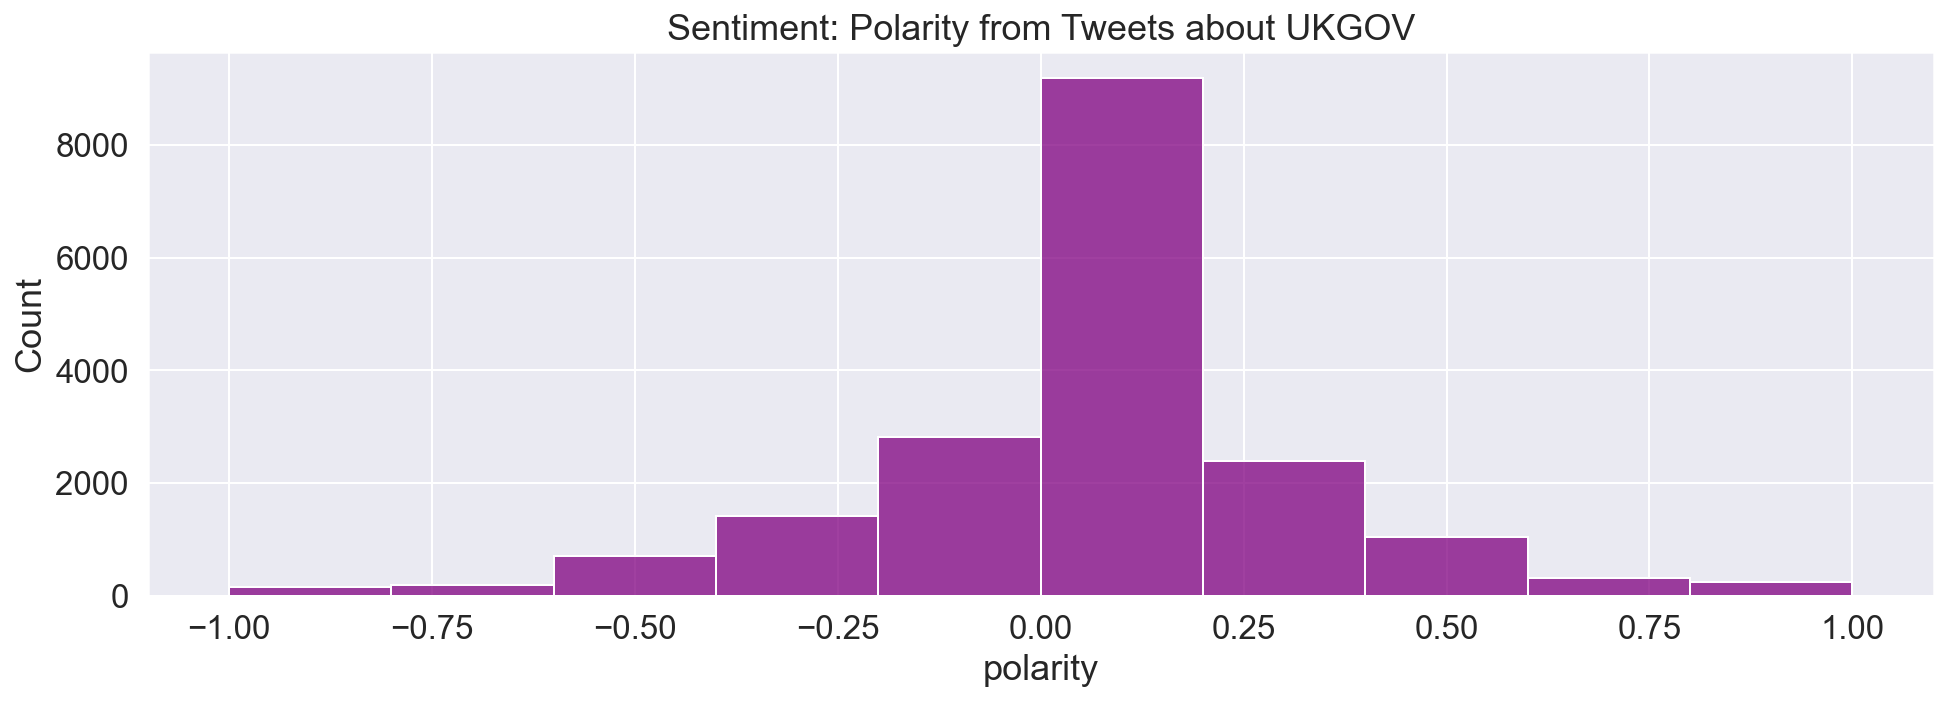

In [33]:
#call styles for plots
styles();

#histogram for polarity
sns.histplot(data=df, x="polarity", bins=[-1,-0.8, -0.6, -0.4, -0.2,0, 0.2, 0.4, 0.6, 0.8,1], color="purple");

plt.title("Sentiment: Polarity from Tweets about UKGOV");
plt.show();

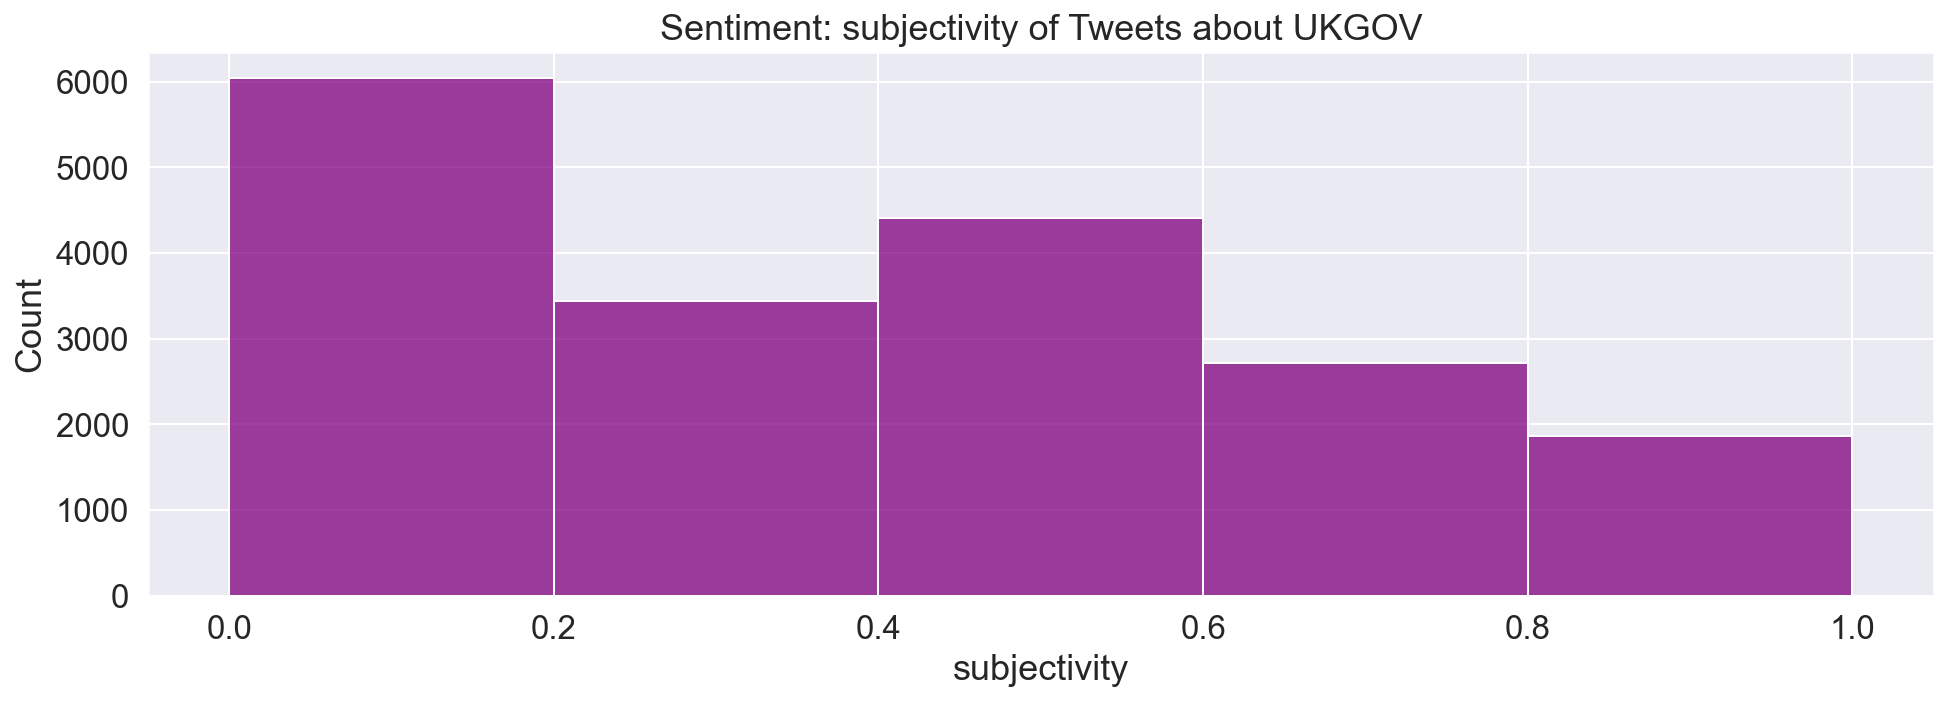

In [34]:
#call styles for plots
styles();

#histogram for polarity
sns.histplot(data=df, x="subjectivity", bins=[0, 0.2, 0.4, 0.6,0.8, 1], color="purple");

plt.title("Sentiment: subjectivity of Tweets about UKGOV");

plt.show();

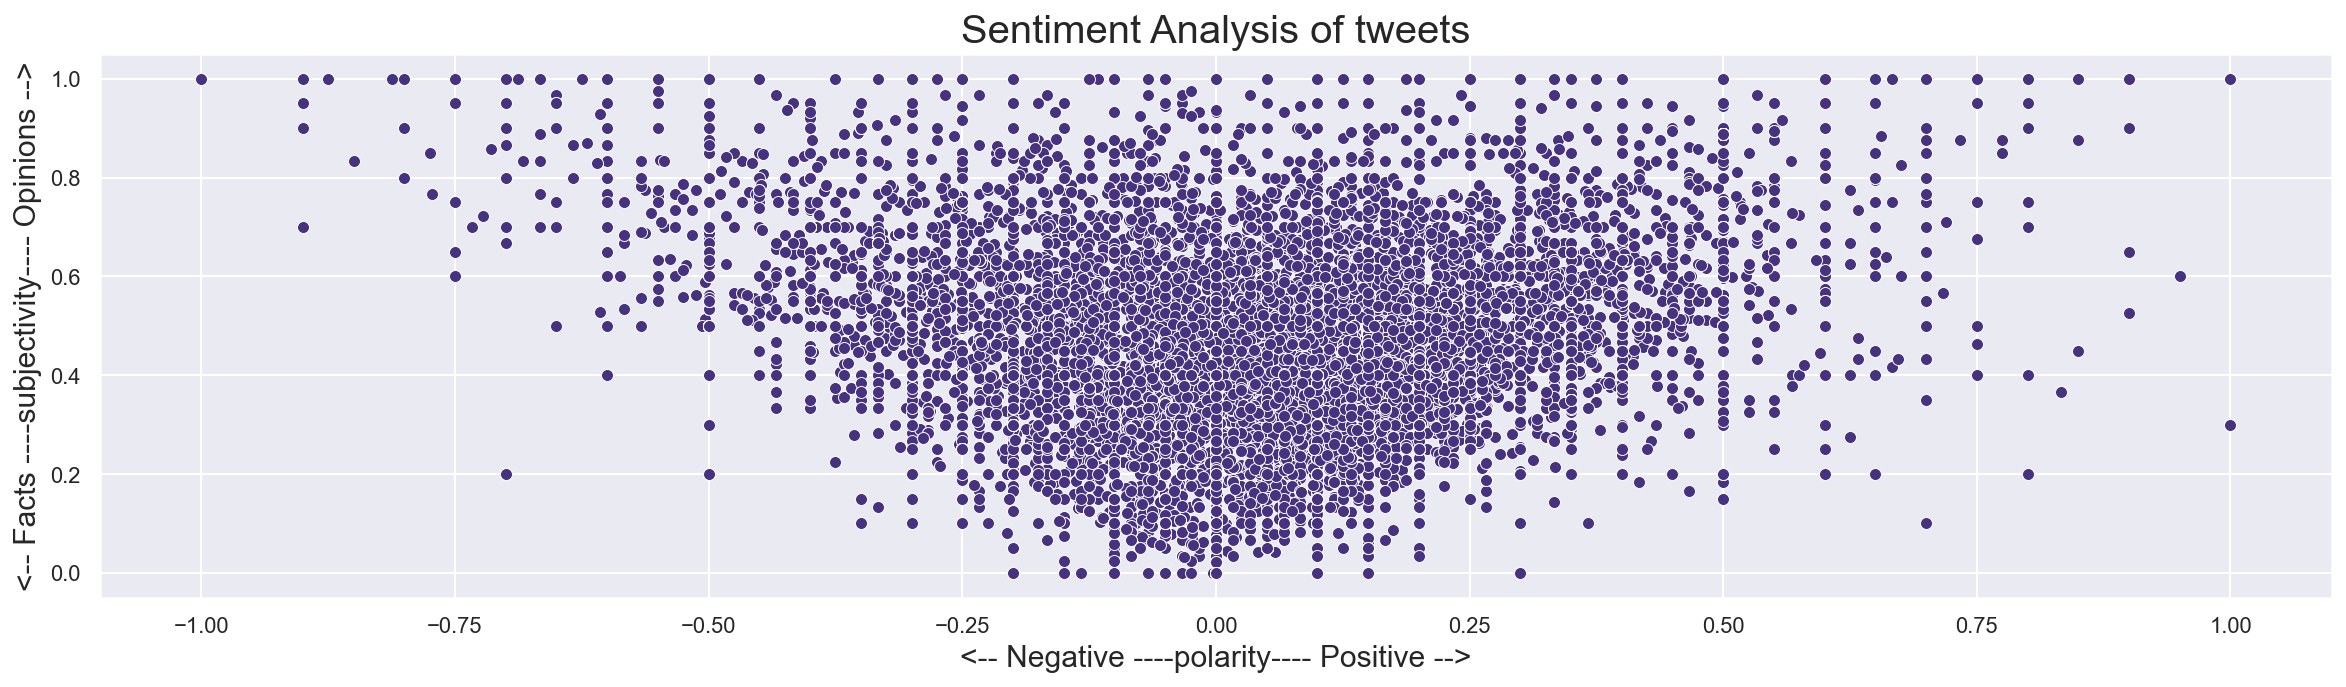

In [35]:
#set to seaborn
sns.set()
#palette="viridis"
sns.set_palette('viridis');
#plot size
plt.figure(figsize=(20, 5));  

sns.scatterplot(data=df, x="polarity", y="subjectivity")

plt.title("Sentiment Analysis of tweets", fontsize=20);
plt.xlabel('<-- Negative ----polarity---- Positive -->', fontsize=15);
plt.ylabel('<-- Facts ----subjectivity---- Opinions -->', fontsize=15);

plt.show();

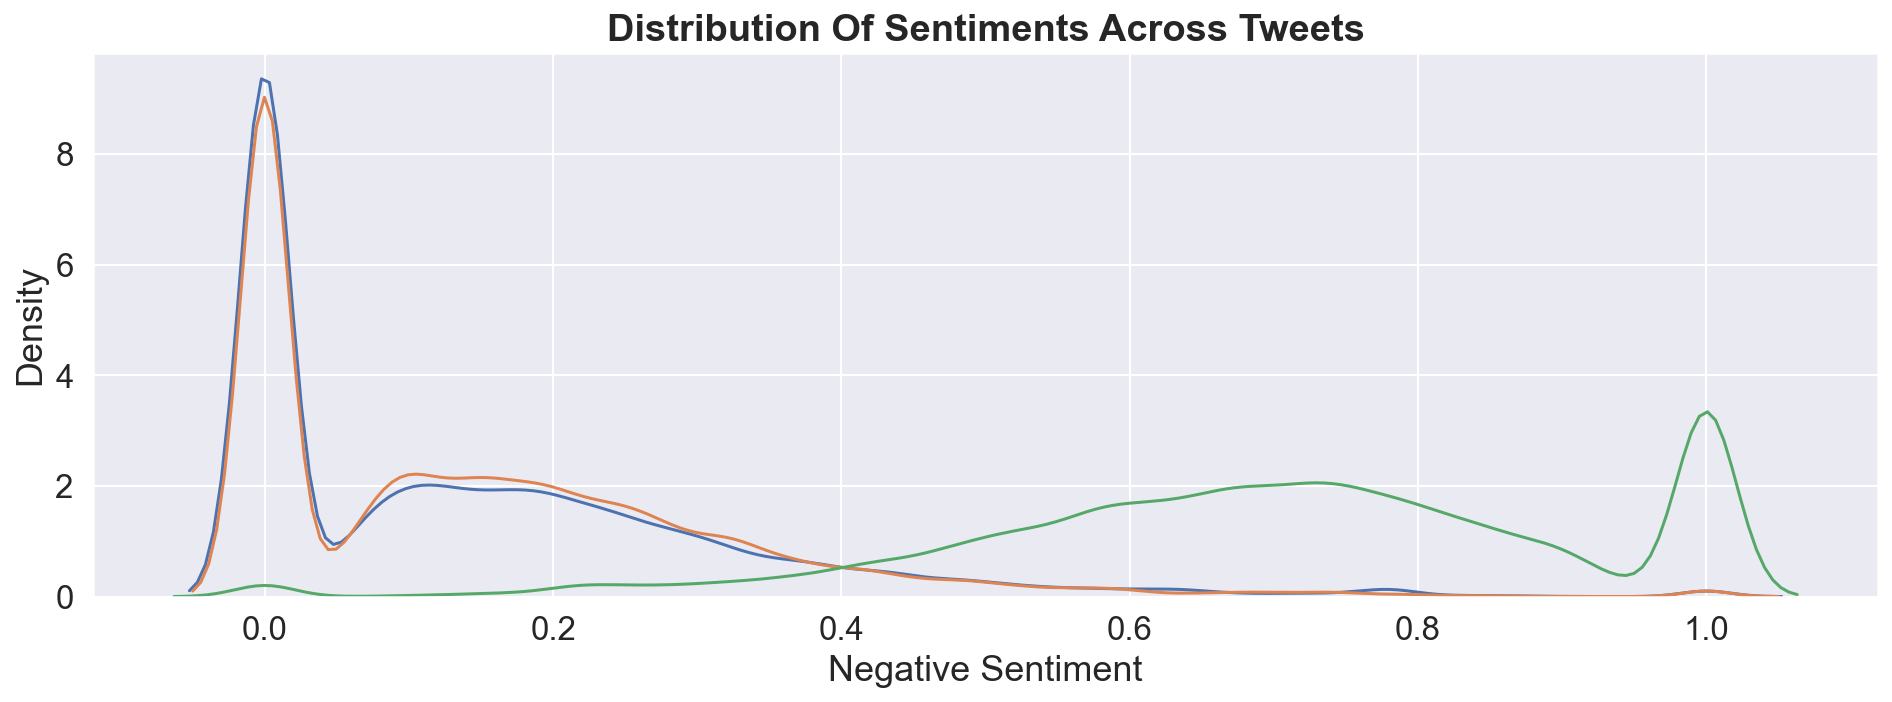

In [36]:
#call styles for plots
styles();

plt.title('Distribution Of Sentiments Across Tweets',fontsize=19,fontweight='bold');
sns.kdeplot(df['Negative Sentiment'],bw=0.1);
sns.kdeplot(df['Positive Sentiment'],bw=0.1);
sns.kdeplot(df['Neutral Sentiment'],bw=0.1);

<AxesSubplot:xlabel='Date', ylabel='Positive Sentiment'>

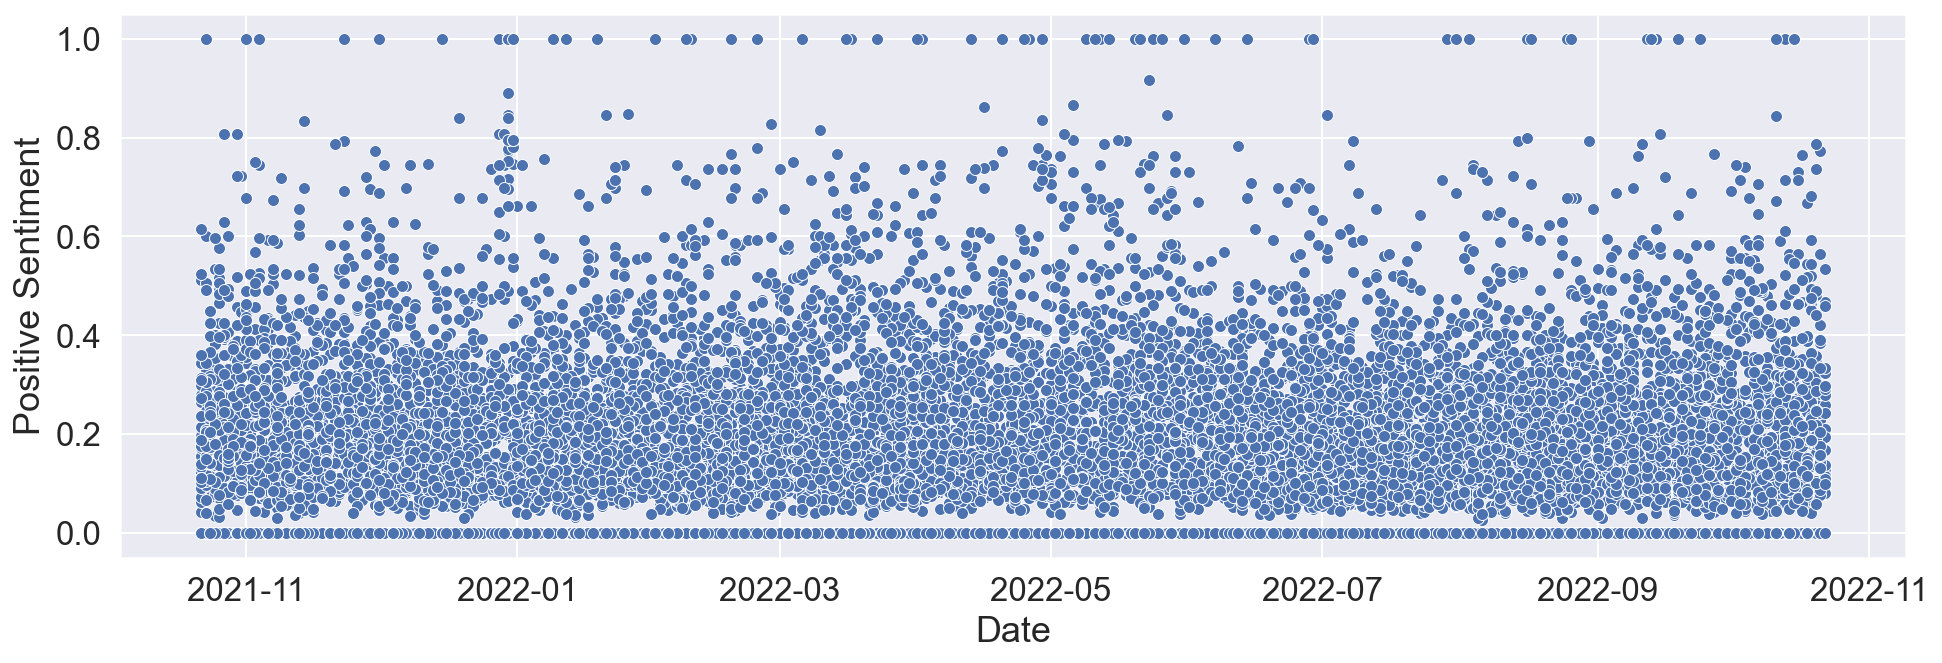

In [37]:
styles();
sns.scatterplot(x=df['Date'], y=df['Positive Sentiment'])

In [38]:
#pip install wordcloud

In [39]:
##Wordcloud Modules
from wordcloud import WordCloud 

In [40]:
def wc(data,bgcolor): # word cloud
    plt.figure(figsize=(10,10))
    wc=WordCloud(background_color=bgcolor,max_words=100, min_word_length=4, contour_width=3, contour_color='viridis')
    wc.generate(" ".join(data)) 
    plt.imshow(wc)
    plt.axis("off")

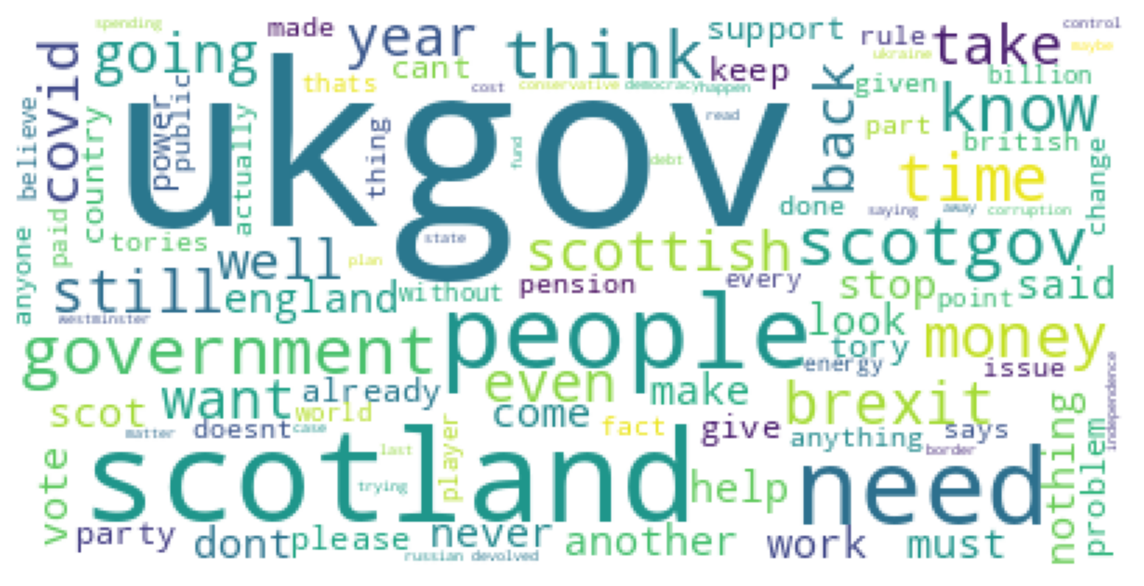

In [41]:
# 0
wc(df[df.polarity==0.0].tweet_clean, 'white')

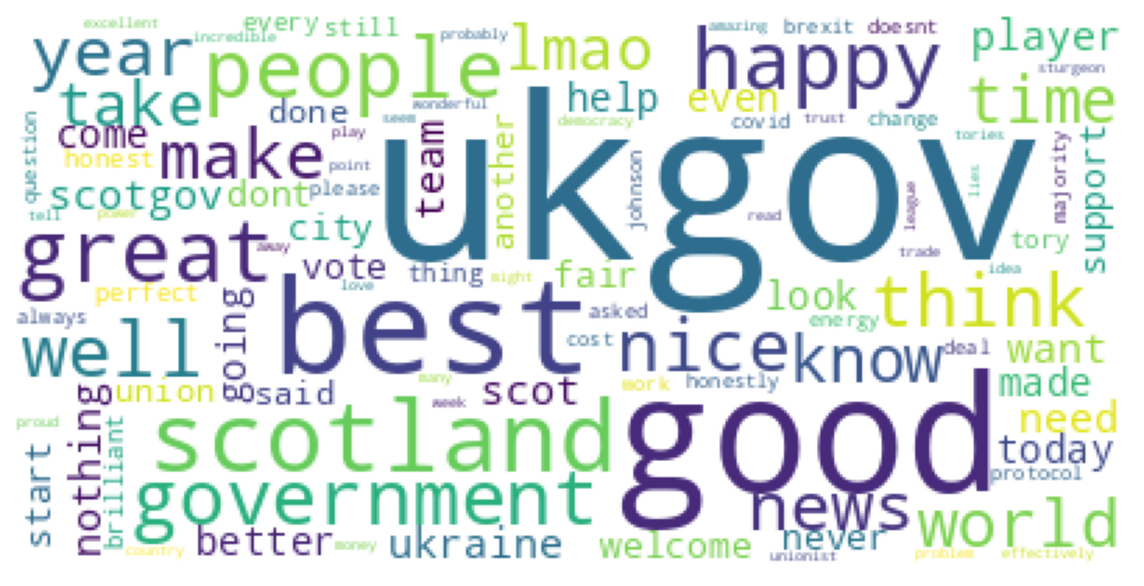

In [42]:
# 0
wc(df[df.polarity>.55].tweet_clean, 'white')

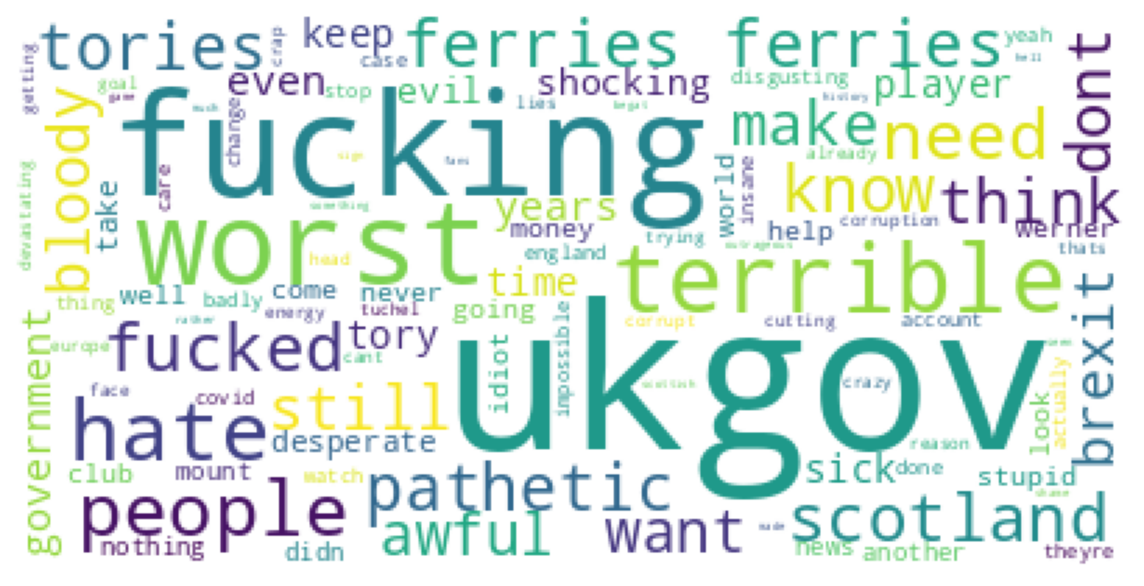

In [43]:
# 0
wc(df[df.polarity<-.55].tweet_clean, 'white')

In [44]:
sns.scatterplot(x=df['Date'], y=df[''])

KeyError: ''

In [ ]:
#creating a sentiment score between 0-100
df['sentiment_score'] = round(df['polarity']*100, 2)
df.head(2)

In [ ]:
#call styles for plots
styles();

sns.lineplot(x='Date', y='polarity', data = df )

In [ ]:
df['sentiment_score']

# Document term matrix

In [220]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words

from sklearn.feature_extraction.text import CountVectorizer

# create a count vectorizer object
cv = CountVectorizer(stop_words="english")

# fit the count vectorizer using the text data
data_cv = cv.fit_transform(df['tweet_clean'])
data_dtm =pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

# Pickle it for later use
import pickle
pickle.dump(cv, open("../data/cv_stop.pkl", "wb"))

data_dtm

aa  aampe  aanes  aare  aas  ab  aback  abandon  abandoned  abandoning  \
0       0      0      0     0    0   0      0        0          0           0   
1       0      0      0     0    0   0      0        0          0           0   
2       0      0      0     0    0   0      0        0          0           0   
3       0      0      0     0    0   0      0        0          0           0   
4       0      0      0     0    0   0      0        0          0           0   
...    ..    ...    ...   ...  ...  ..    ...      ...        ...         ...   
18476   0      0      0     0    0   0      0        0          0           0   
18477   0      0      0     0    0   0      0        0          0           0   
18478   0      0      0     0    0   0      0        0          0           0   
18479   0      0      0     0    0   0      0        0          0           0   
18480   0      0      0     0    0   0      0        0          0           0   

       ...  zoning  zoo  zoological  zoom  zoomers  zouma  zubair  ánd  \
0      ...       0    0           0     0        0      0       0    0   
1      ...       0    0           0     0        0      0       0    0   
2      ...       0    0           0     0        0      0       0    0   
3      ...       0    0           0     0        0      0       0    0   
4      ...       0    0           0     0        0      0       0    0   
...    ...     ...  ...         ...   ...      ...    ...     ...  ...   
18476  ...       0    0           0     0        0      0       0    0   
18477  ...       0    0           0     0        0      0       0    0   
18478  ...       0    0           0     0        0      0       0    0   
18479  ...       0    0           0     0        0      0       0    0   
18480  ...       0    0           0     0        0      0       0    0   

       çareally  پاکستانزندہباد  
0             0               0  
1             0               0  
2             0               0  
3             0               0  
4             0               0  
...         ...             ...  
18476         0               0  
18477         0               0  
18478         0               0  
18479         0               0  
18480         0               0  

[18481 rows x 33996 columns]

In [221]:
#Gensism Python framework for fast Vector Space Modelling
from gensim import matutils, models
#ndustrial-strength Natural Language Processing (NLP) in Python
import scipy.sparse

## Topic modelling

In [222]:
# One of the required inputs is a term-document matrix
data_dtm = data_dtm.transpose()
data_dtm.head()

0      1      2      3      4      5      6      7      8      9      \
aa         0      0      0      0      0      0      0      0      0      0   
aampe      0      0      0      0      0      0      0      0      0      0   
aanes      0      0      0      0      0      0      0      0      0      0   
aare       0      0      0      0      0      0      0      0      0      0   
aas        0      0      0      0      0      0      0      0      0      0   

       ...  18471  18472  18473  18474  18475  18476  18477  18478  18479  \
aa     ...      0      0      0      0      0      0      0      0      0   
aampe  ...      0      0      0      0      0      0      0      0      0   
aanes  ...      0      0      0      0      0      0      0      0      0   
aare   ...      0      0      0      0      0      0      0      0      0   
aas    ...      0      0      0      0      0      0      0      0      0   

       18480  
aa         0  
aampe      0  
aanes      0  
aare       0  
aas        0  

[5 rows x 18481 columns]

In [61]:
# turn term matrix into a sparse matrix
sparse_counts = scipy.sparse.csr_matrix(data_dtm)
#Convert a Scipy.sparse vector into the Gensim bag-of-words format
corpus = matutils.Sparse2Corpus(sparse_counts)

In [223]:
# collect the vocabulary items used in the count vectorizer
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [224]:
# Train the model on the corpus.
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

[(0,
  '0.019*"ukgov" + 0.005*"like" + 0.004*"good" + 0.003*"got" + 0.003*"shit" + 0.003*"fuck" + 0.003*"covid" + 0.003*"man" + 0.003*"time" + 0.003*"ve"'),
 (1,
  '0.056*"ukgov" + 0.012*"uk" + 0.011*"amp" + 0.008*"scotland" + 0.005*"people" + 0.004*"eu" + 0.004*"brexit" + 0.003*"scotgov" + 0.003*"money" + 0.003*"government"')]

In [225]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda.print_topics()

[(0,
  '0.035*"ukgov" + 0.013*"amp" + 0.009*"uk" + 0.006*"people" + 0.003*"need" + 0.003*"ukraine" + 0.003*"british" + 0.003*"covid" + 0.003*"stop" + 0.002*"website"'),
 (1,
  '0.041*"ukgov" + 0.006*"like" + 0.005*"eu" + 0.005*"brexit" + 0.005*"time" + 0.004*"uk" + 0.004*"amp" + 0.004*"think" + 0.003*"good" + 0.003*"don"'),
 (2,
  '0.055*"ukgov" + 0.013*"scotland" + 0.012*"uk" + 0.010*"amp" + 0.006*"scotgov" + 0.006*"money" + 0.005*"people" + 0.004*"scottish" + 0.004*"snp" + 0.004*"pay"')]

In [226]:
# LDA for num_topics = 4
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda.print_topics()

[(0,
  '0.021*"ukgov" + 0.005*"good" + 0.003*"like" + 0.003*"ukraine" + 0.003*"ppe" + 0.003*"covid" + 0.003*"putin" + 0.003*"got" + 0.003*"days" + 0.003*"advice"'),
 (1,
  '0.008*"fuck" + 0.007*"man" + 0.007*"shit" + 0.005*"fucking" + 0.005*"like" + 0.005*"win" + 0.005*"club" + 0.004*"ve" + 0.004*"city" + 0.004*"play"'),
 (2,
  '0.058*"ukgov" + 0.013*"amp" + 0.010*"uk" + 0.008*"people" + 0.004*"government" + 0.004*"dont" + 0.004*"like" + 0.003*"think" + 0.003*"say" + 0.003*"know"'),
 (3,
  '0.056*"ukgov" + 0.014*"scotland" + 0.013*"uk" + 0.010*"amp" + 0.006*"money" + 0.006*"brexit" + 0.005*"eu" + 0.005*"scottish" + 0.004*"snp" + 0.004*"pay"')]

In [227]:
# LDA for num_topics = 5
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, passes=10)
lda.print_topics()

[(0,
  '0.039*"ukgov" + 0.010*"energy" + 0.010*"tax" + 0.009*"pay" + 0.008*"scotland" + 0.007*"uk" + 0.007*"money" + 0.006*"spending" + 0.005*"debt" + 0.005*"oil"'),
 (1,
  '0.024*"ukgov" + 0.004*"like" + 0.003*"got" + 0.003*"united" + 0.003*"twitter" + 0.003*"decide" + 0.003*"actually" + 0.003*"lol" + 0.002*"going" + 0.002*"minister"'),
 (2,
  '0.067*"ukgov" + 0.014*"amp" + 0.014*"uk" + 0.009*"scotland" + 0.008*"people" + 0.006*"eu" + 0.005*"brexit" + 0.005*"dont" + 0.005*"think" + 0.004*"know"'),
 (3,
  '0.010*"shit" + 0.010*"fuck" + 0.010*"man" + 0.007*"fucking" + 0.005*"good" + 0.005*"mount" + 0.005*"game" + 0.004*"liverpool" + 0.004*"players" + 0.004*"player"'),
 (4,
  '0.031*"ukgov" + 0.011*"amp" + 0.005*"uk" + 0.005*"need" + 0.004*"ll" + 0.004*"time" + 0.004*"like" + 0.003*"new" + 0.003*"city" + 0.003*"staff"')]

# Topic Modeling - Attempt #2 (Nouns Only)¶

In [228]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [229]:
# Apply the nouns function to the transcripts to filter only on nouns
df['data_nouns'] = pd.DataFrame(df.tweet_clean.apply(nouns))
df.head(5)

Datetime             Tweet ID  \
0 2021-10-22 10:08:21+00:00  1451490603766886402   
1 2021-10-26 16:29:15+00:00  1453036010149978115   
2 2021-10-29 23:23:59+00:00  1454227542680948738   
3 2021-11-01 14:35:47+00:00  1455181783377629197   
4 2021-11-02 18:57:34+00:00  1455610051608162312   

                                                                                                                                                                                                                                                                                                                      Text  \
0                                                              Missed our recent webinar with partners Social Value Business? We covered lots about Social Value and how the procurement landscape has changed (for the better) because of it. https://t.co/6XAa0MkG7i #SocialValue #Gov #Procurement #PublicSector #UKGov   
1                                                                  @DavidPa80122564 I think the ukgov are afraid people won't be able to cope with how wonderful the sunlit uplands will be and begged the EU for an extension to the "#brexit easement" period.\n\nIt was due to end in July 2021 https://t.co/03RoQfFVGt   
2                                                                                                                                                                           @TerrorismPolice The irony...#UKGov know most of them, being UKGov allowed many of them back into the country.\n#UKGovAndTheirIllegalProxywars   
3                                                   The UKGov report implies any therapy which isnt “affirming” &amp; which doesnt provide access to transition related healthcare is “gender identity conversion therapy” &amp; ignores emerging evidence that “affirming” has in fact caused harm to detransitioners /14   
4  @flodwyns @BlokeOnWheels @SandraDunn1955 The organisation of COP26 is UKGov led. Inside the BLUE zone itself, the whole area is responsibility of the UK and UN.\n\nUnfortunately, ScotGov has no official role at COP or in organising, altho our First Minister has been welcoming delegates to Scotland and Glasgow.   

          Username  retweetCount  likeCount  \
0        AdviceGov             0          0   
1  gylesnamopaleen             0          1   
2        KSmth2000             0          0   
3    luluskip2malu             1          1   
4  jimmerfaestoney             0          0   

                                                         hashtags        Date  \
0  ['SocialValue', 'Gov', 'Procurement', 'PublicSector', 'UKGov']  2021-10-22   
1                                                      ['brexit']  2021-10-26   
2                      ['UKGov', 'UKGovAndTheirIllegalProxywars']  2021-10-29   
3                                                                  2021-11-01   
4                                                                  2021-11-02   

   Month  Year  ...  stopwords  hashtag_count  \
0     10  2021  ...         10              5   
1     10  2021  ...         19              0   
2     10  2021  ...          7              1   
3     11  2021  ...          9              0   
4     11  2021  ...         18              0   

                                                                                                                                                                                                             tweet_clean  \
0                                                     missed recent webinar partners social value business covered lots social value procurement landscape changed better socialvalue gov procurement publicsector ukgov   
1                                                                                            think ukgov afraid people wont able cope wonderful sunlit uplands begged eu extension brexit easement periodit due end july   
2                                                                       

In [230]:
pd.set_option('display.max_colwidth', None)

df_subset = df[["Text", "hashtags", "tweet_clean", "data_nouns"]]
df_subset.head() 

Text  \
0                                                              Missed our recent webinar with partners Social Value Business? We covered lots about Social Value and how the procurement landscape has changed (for the better) because of it. https://t.co/6XAa0MkG7i #SocialValue #Gov #Procurement #PublicSector #UKGov   
1                                                                  @DavidPa80122564 I think the ukgov are afraid people won't be able to cope with how wonderful the sunlit uplands will be and begged the EU for an extension to the "#brexit easement" period.\n\nIt was due to end in July 2021 https://t.co/03RoQfFVGt   
2                                                                                                                                                                           @TerrorismPolice The irony...#UKGov know most of them, being UKGov allowed many of them back into the country.\n#UKGovAndTheirIllegalProxywars   
3                                                   The UKGov report implies any therapy which isnt “affirming” &amp; which doesnt provide access to transition related healthcare is “gender identity conversion therapy” &amp; ignores emerging evidence that “affirming” has in fact caused harm to detransitioners /14   
4  @flodwyns @BlokeOnWheels @SandraDunn1955 The organisation of COP26 is UKGov led. Inside the BLUE zone itself, the whole area is responsibility of the UK and UN.\n\nUnfortunately, ScotGov has no official role at COP or in organising, altho our First Minister has been welcoming delegates to Scotland and Glasgow.   

                                                         hashtags  \
0  ['SocialValue', 'Gov', 'Procurement', 'PublicSector', 'UKGov']   
1                                                      ['brexit']   
2                      ['UKGov', 'UKGovAndTheirIllegalProxywars']   
3                                                                   
4                                                                   

                                                                                                                                                                                                             tweet_clean  \
0                                                     missed recent webinar partners social value business covered lots social value procurement landscape changed better socialvalue gov procurement publicsector ukgov   
1                                                                                            think ukgov afraid people wont able cope wonderful sunlit uplands begged eu extension brexit easement periodit due end july   
2                                                                                                                                           ironyukgov know ukgov allowed many back countryukgovandtheirillegalproxywars   
3  ukgov report implies therapy isnt “affirming” amp doesnt provide access transition related healthcare “gender identity conversion therapy” amp ignores emerging evidence “affirming” fact caused harm detransitioners   
4                                    organisation ukgov led inside blue zone whole area responsibility uk ununfortunately scotgov official role cop organising altho first minister welcoming delegates scotland glasgow   

                                                                                                                                   data_nouns  
0                                     partners value business lots value procurement landscape socialvalue gov procurement publicsector ukgov  
1                                                                      people cope sunlit uplands extension brexit easement periodit end july  
2                                                                                             ironyukgov countryukgovandtheirillegalproxywars  
3  report implies “ doesnt access transition healthcare gender identity conversion therap

In [231]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said', 'amp', 'ukgov']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(df.data_nouns)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())

data_dtmn

aampe  aanes  aas  abandon  abandonment  abandons  abatingnot  abd  \
0          0      0    0        0            0         0           0    0   
1          0      0    0        0            0         0           0    0   
2          0      0    0        0            0         0           0    0   
3          0      0    0        0            0         0           0    0   
4          0      0    0        0            0         0           0    0   
...      ...    ...  ...      ...          ...       ...         ...  ...   
18476      0      0    0        0            0         0           0    0   
18477      0      0    0        0            0         0           0    0   
18478      0      0    0        0            0         0           0    0   
18479      0      0    0        0            0         0           0    0   
18480      0      0    0        0            0         0           0    0   

       abdel  abdicatesconstitution  ...  zombie  zone  zoneits  zones  \
0          0                      0  ...       0     0        0      0   
1          0                      0  ...       0     0        0      0   
2          0                      0  ...       0     0        0      0   
3          0                      0  ...       0     0        0      0   
4          0                      0  ...       0     1        0      0   
...      ...                    ...  ...     ...   ...      ...    ...   
18476      0                      0  ...       0     0        0      0   
18477      0                      0  ...       0     0        0      0   
18478      0                      0  ...       0     0        0      0   
18479      0                      0  ...       0     0        0      0   
18480      0                      0  ...       0     0        0      0   

       zonestbf  zoo  zoom  zoomers  zouma  zubair  
0             0    0     0        0      0       0  
1             0    0     0        0      0       0  
2             0    0     0        0      0       0  
3             0    0     0        0      0       0  
4             0    0     0        0      0       0  
...         ...  ...   ...      ...    ...     ...  
18476         0    0     0        0      0       0  
18477         0    0     0        0      0       0  
18478         0    0     0        0      0       0  
18479         0    0     0        0      0       0  
18480         0    0     0        0      0       0  

[18481 rows x 20913 columns]

In [232]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [233]:
# Let's start with 2 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=2, id2word=id2wordn, passes=10)
ldan.print_topics()

KeyboardInterrupt: 

In [ ]:
# Let's try topics = 3
ldan = models.LdaModel(corpus=corpusn, num_topics=3, id2word=id2wordn, passes=10)
ldan.print_topics()

In [ ]:
# Let's try 4 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=10)
ldan.print_topics()

## Topic Modeling - Attempt #3 (Nouns and Adjectives)

In [ ]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [ ]:
df[['data_nouns_adj']]

In [97]:
# Apply the nouns function to the transcripts to filter only on nouns
df['data_nouns_adj'] = pd.DataFrame(df.tweet_clean.apply(nouns_adj))

In [98]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(df.data_nouns_adj)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())


In [99]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [100]:
# Let's try 3 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=3, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.018*"uk" + 0.013*"scotland" + 0.008*"money" + 0.007*"scotgov" + 0.007*"brexit" + 0.006*"eu" + 0.006*"scottish" + 0.005*"snp" + 0.005*"tax" + 0.005*"years"'),
 (1,
  '0.008*"uk" + 0.004*"covid" + 0.004*"fuck" + 0.004*"new" + 0.004*"shit" + 0.003*"way" + 0.003*"man" + 0.003*"refugees" + 0.003*"protocol" + 0.003*"help"'),
 (2,
  '0.006*"uk" + 0.005*"good" + 0.004*"government" + 0.004*"pm" + 0.003*"today" + 0.003*"website" + 0.003*"party" + 0.003*"johnson" + 0.003*"ve" + 0.003*"minister"')]

In [101]:
# Let's try 4 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.011*"uk" + 0.010*"brexit" + 0.009*"eu" + 0.006*"law" + 0.006*"good" + 0.006*"scotland" + 0.005*"government" + 0.005*"vote" + 0.005*"democracy" + 0.004*"tory"'),
 (1,
  '0.019*"uk" + 0.006*"scotland" + 0.004*"gov" + 0.004*"british" + 0.004*"new" + 0.004*"pension" + 0.003*"russian" + 0.003*"state" + 0.003*"oil" + 0.003*"country"'),
 (2,
  '0.007*"man" + 0.006*"fuck" + 0.005*"shit" + 0.005*"ve" + 0.004*"city" + 0.004*"club" + 0.004*"player" + 0.004*"good" + 0.004*"chelsea" + 0.004*"mount"'),
 (3,
  '0.014*"uk" + 0.011*"money" + 0.011*"scotland" + 0.008*"tax" + 0.006*"energy" + 0.006*"scotgov" + 0.006*"years" + 0.005*"government" + 0.005*"pay" + 0.005*"covid"')]

In [102]:
# Let's try 5 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=5, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.021*"scotland" + 0.018*"uk" + 0.010*"scotgov" + 0.010*"money" + 0.009*"scottish" + 0.008*"snp" + 0.008*"tax" + 0.006*"government" + 0.006*"scots" + 0.006*"independence"'),
 (1,
  '0.014*"uk" + 0.006*"public" + 0.006*"covid" + 0.005*"ukraine" + 0.005*"government" + 0.004*"russian" + 0.004*"support" + 0.004*"tests" + 0.004*"war" + 0.004*"british"'),
 (2,
  '0.008*"man" + 0.007*"shit" + 0.006*"ve" + 0.005*"city" + 0.005*"club" + 0.005*"player" + 0.004*"mount" + 0.004*"game" + 0.004*"players" + 0.004*"bad"'),
 (3,
  '0.015*"uk" + 0.010*"energy" + 0.008*"eu" + 0.006*"good" + 0.006*"brexit" + 0.005*"new" + 0.004*"border" + 0.004*"years" + 0.004*"law" + 0.004*"covid"'),
 (4,
  '0.005*"fuck" + 0.005*"way" + 0.005*"chelsea" + 0.004*"worse" + 0.004*"uk" + 0.003*"ukgovs" + 0.003*"refugees" + 0.003*"likely" + 0.003*"sorry" + 0.003*"team"')]

In [103]:
# Let's try 5 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=6, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.009*"ukraine" + 0.006*"list" + 0.005*"refugees" + 0.004*"twitter" + 0.004*"war" + 0.004*"borisjohnson" + 0.004*"policy" + 0.004*"claim" + 0.004*"biggest" + 0.003*"thank"'),
 (1,
  '0.016*"energy" + 0.009*"covid" + 0.009*"cost" + 0.009*"years" + 0.007*"uk" + 0.007*"crisis" + 0.004*"deaths" + 0.004*"fuel" + 0.004*"new" + 0.004*"news"'),
 (2,
  '0.022*"uk" + 0.007*"tax" + 0.007*"public" + 0.005*"support" + 0.005*"british" + 0.005*"government" + 0.005*"eu" + 0.005*"taxes" + 0.004*"companies" + 0.004*"oil"'),
 (3,
  '0.011*"brexit" + 0.011*"eu" + 0.007*"law" + 0.007*"border" + 0.007*"referendum" + 0.007*"ni" + 0.006*"international" + 0.006*"court" + 0.005*"uk" + 0.005*"vote"'),
 (4,
  '0.028*"scotland" + 0.022*"uk" + 0.014*"scotgov" + 0.013*"money" + 0.011*"snp" + 0.009*"scottish" + 0.008*"scots" + 0.007*"independence" + 0.006*"government" + 0.006*"tory"'),
 (5,
  '0.008*"good" + 0.007*"corruption" + 0.005*"government" + 0.005*"man" + 0.005*"rights" + 0.005*"don" + 0.005*"uk" + 0.

# Average Sentiment

In [50]:
df_new=df[['Date', 'compound']]
df_new.sort_values(by='Date', inplace=True)

df_new["Date"]= pd.to_datetime(df_new["Date"])

compound_avg = df_new.resample('D', on='Date').mean()
compound_week = df_new.resample('W', on='Date').mean()
compound_month = df_new.resample('M', on='Date').mean()

compound_avg.rename(columns={'compound': 'compound_daily'}, inplace=True)
compound_week.rename(columns={'compound': 'compound_week'}, inplace=True)
compound_month.rename(columns={'compound': 'compound_month'}, inplace=True)

In [51]:
#df_new['day'] = df_new.index.apply(lambda x: x.Date()) 
#davg.reset_index('Date/Time', inplace=True)

df_cmpd_avg = pd.merge(df_new, compound_avg, on='Date')
#df_cmpd_2 = pd.merge(df_cmpd_avg , compound_week,left_by="Date")
#df_cmpd_avg = pd.merge(df_cmpd_avg , compound_month, left_on='Date',right_on='Date')

#df_cmpd_avg

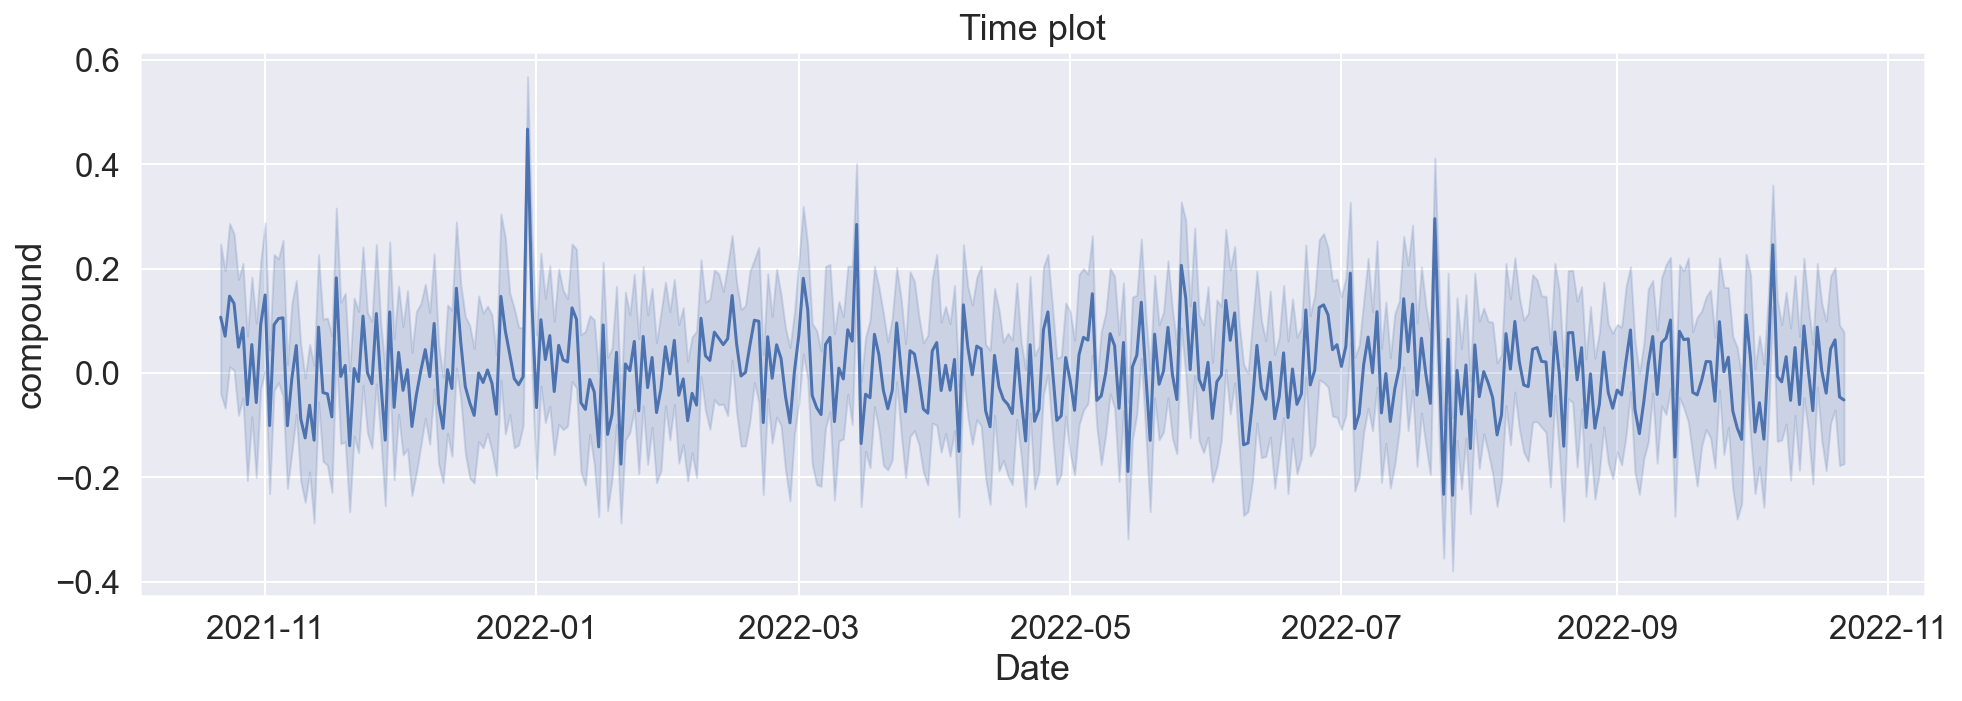

In [52]:
styles();

sns.lineplot(x=df_cmpd_avg['Date'], y=df_cmpd_avg['compound']);

plt.title("Time plot");

In [53]:
#pip install skforecast
#pip install xgboost

In [54]:
# Modeling and Forecasting
# ==============================================================================
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [55]:
type(df_cmpd_avg)

pandas.core.frame.DataFrame

In [56]:
df_cmpd_avg['Date'].min()
df_cmpd_avg['Date'].max()

Timestamp('2022-10-22 00:00:00')

In [57]:
#df_cmpd_avg
df_cmpd_avg = df_cmpd_avg.set_index('Date')
df_cmpd_avg= df_cmpd_avg.sort_index()

In [58]:
train_date = '2022-06-22 00:00:00'
val_date = '2022-08-22 00:00:00'
train = df_cmpd_avg.loc[: train_date].copy()
val = df_cmpd_avg.loc[train_date:val_date].copy()
test = df_cmpd_avg.loc[val_date :].copy()

In [59]:
print(f"Dates train      : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Dates validation      : {val.index.min()} --- {val.index.max()}  (n={len(val)})")
print(f"Dates test       : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Dates train      : 2021-10-22 00:00:00 --- 2022-06-22 00:00:00  (n=12316)
Dates validation      : 2022-06-22 00:00:00 --- 2022-08-22 00:00:00  (n=3152)
Dates test       : 2022-08-22 00:00:00 --- 2022-10-22 00:00:00  (n=3115)


<Figure size 1152x360 with 0 Axes>

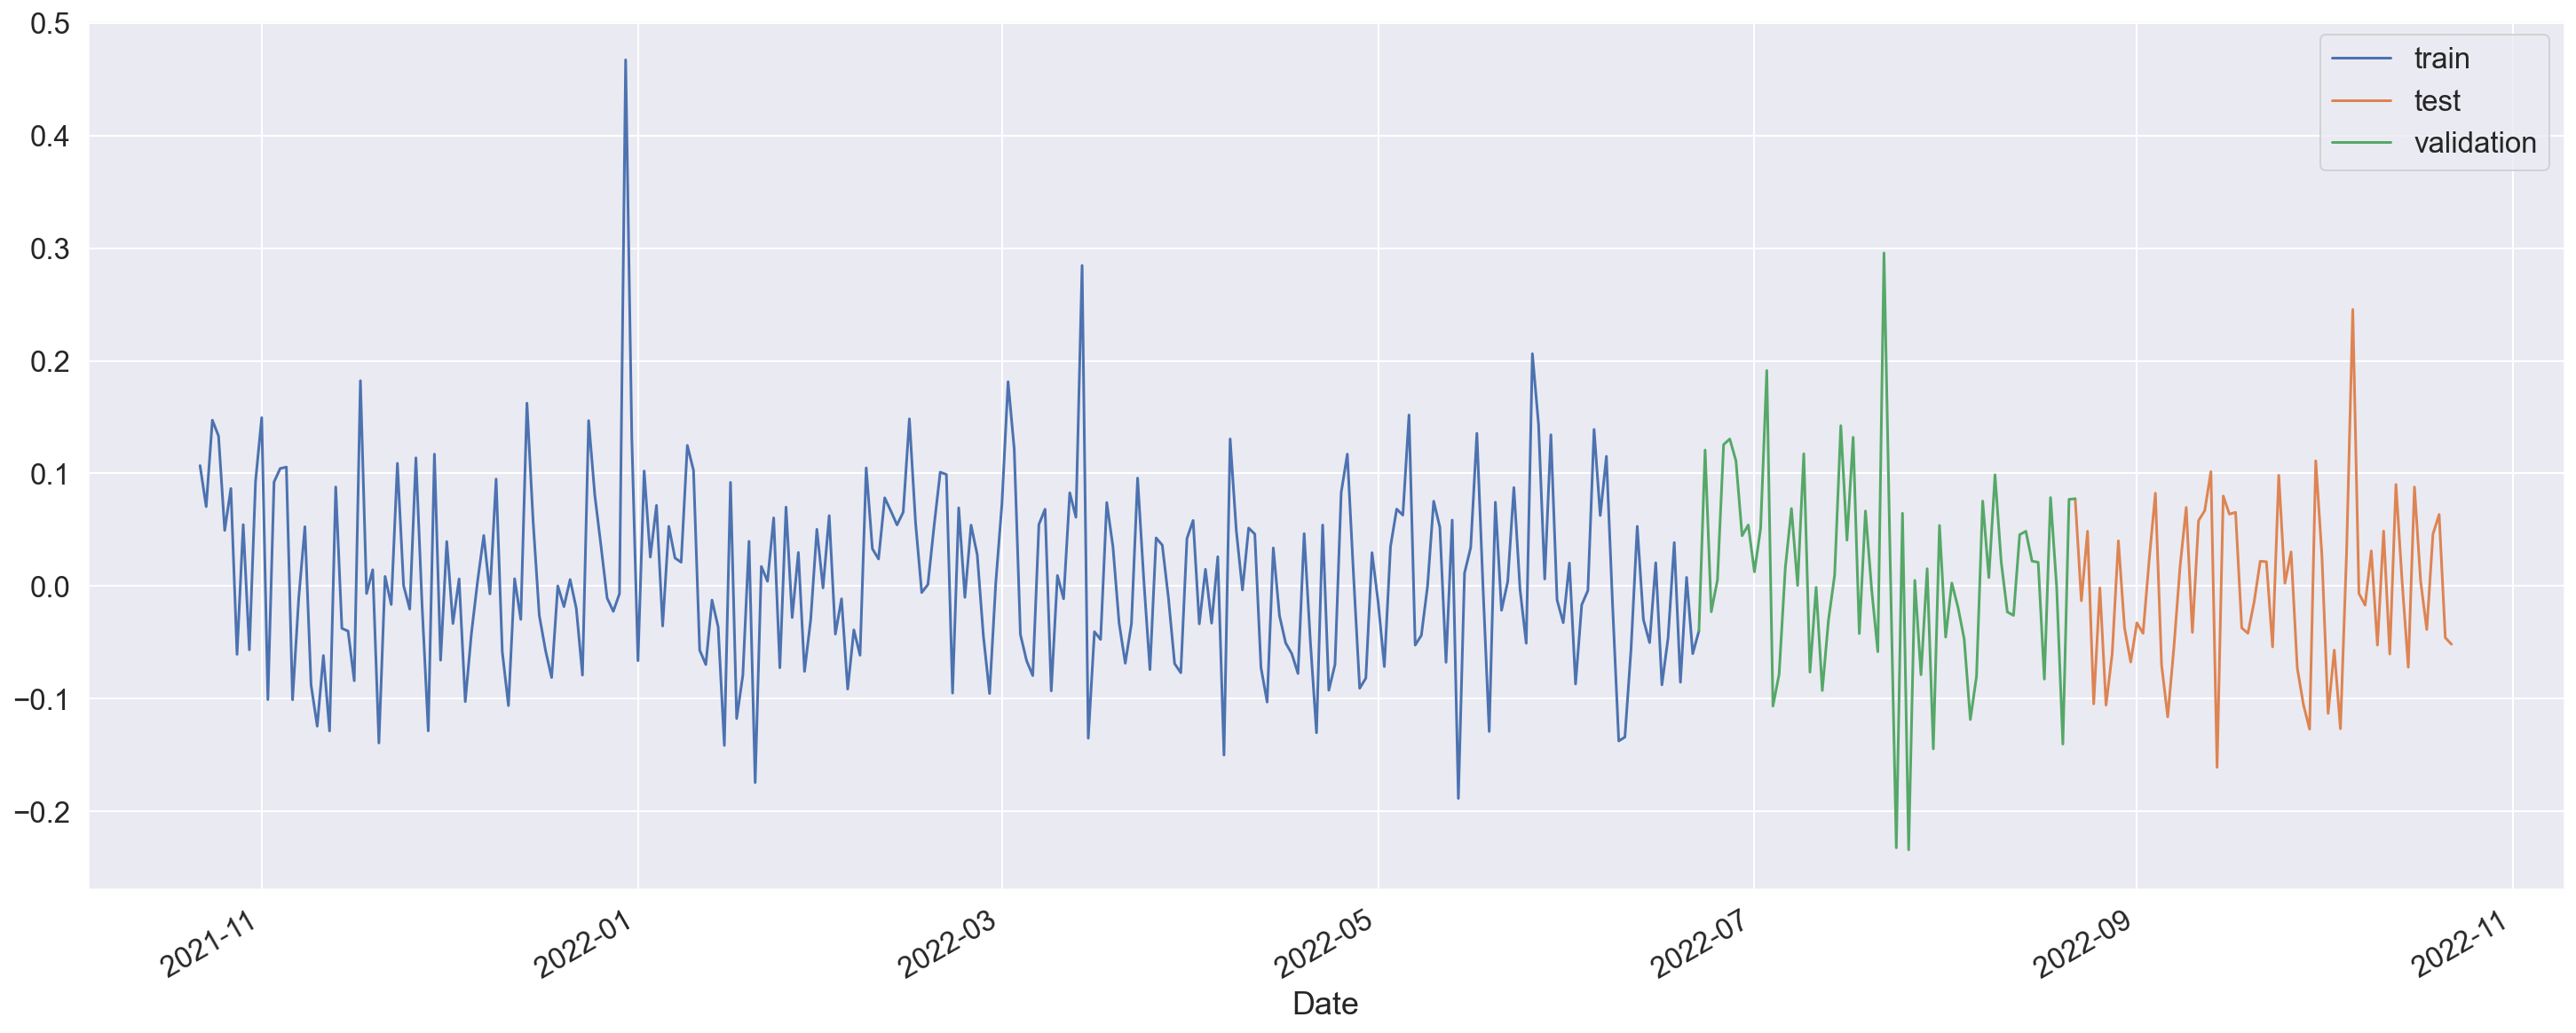

In [60]:
#plt.style.use('dark_background')
styles();
fig,ax = plt.subplots(figsize=(25,10));
train['compound_daily'].plot(ax=ax,label='train');
test['compound_daily'].plot(ax=ax,label='test');
val['compound_daily'].plot(ax=ax,label='validation');

ax.legend();

XGBoost is a very efficient stochastic gradient boosting which is very popular for used. With it's own API and XGBRegressor class that follow scikit learn API make it compatible with skforecast.

In [61]:
# Create forecaster
forecaster = ForecasterAutoreg(
                regressor = xgb.XGBRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=123,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: N

In [62]:
# Grid search of hyperparameters and lags
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# # Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = df_cmpd_avg.loc[:val_date, 'compound'], # Train and validation data
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = 24,
    refit              = False,
    metric             = 'mean_squared_error',
    initial_train_size = int(len(train)), # Model is trained with training data
    fixed_train_size   = False,
    return_best        = True,
    verbose            = False
    )

Number of models compared: 48.


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [07:29<00:00, 112.28s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.24825073762335462



In [ ]:
results_grid.head(10)

In [ ]:
# Backtesting
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = df_cmpd_avg['compound'],
    initial_train_size = len(df_cmpd_avg.loc[:val_date]),
    fixed_train_size   = False,
    steps      = 24,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
)

In [ ]:
print(f"Backtest error: {metric}")

In [ ]:
# Index is added to predictions
#predictions.index = test.index

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_cmpd_avg.compound.tolist(), lags=50, ax=axes[0])
plot_pacf(df_cmpd_avg.compound.tolist(), lags=50, ax=axes[1])

In [71]:
#pip install statsmodels --upgrade

In [72]:
from sklearn.preprocessing import MinMaxScaler

In [73]:
trans = MinMaxScaler()
x = df_cmpd_avg['compound']
data = trans.fit_transform(x)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.670501 -0.318199  0.177901 ...  0.401901  0.726901  0.631201].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
%matplotlib inline


# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_cmpd_avg['compound'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df_cmpd_avg['compound'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

<Figure size 1152x360 with 0 Axes>

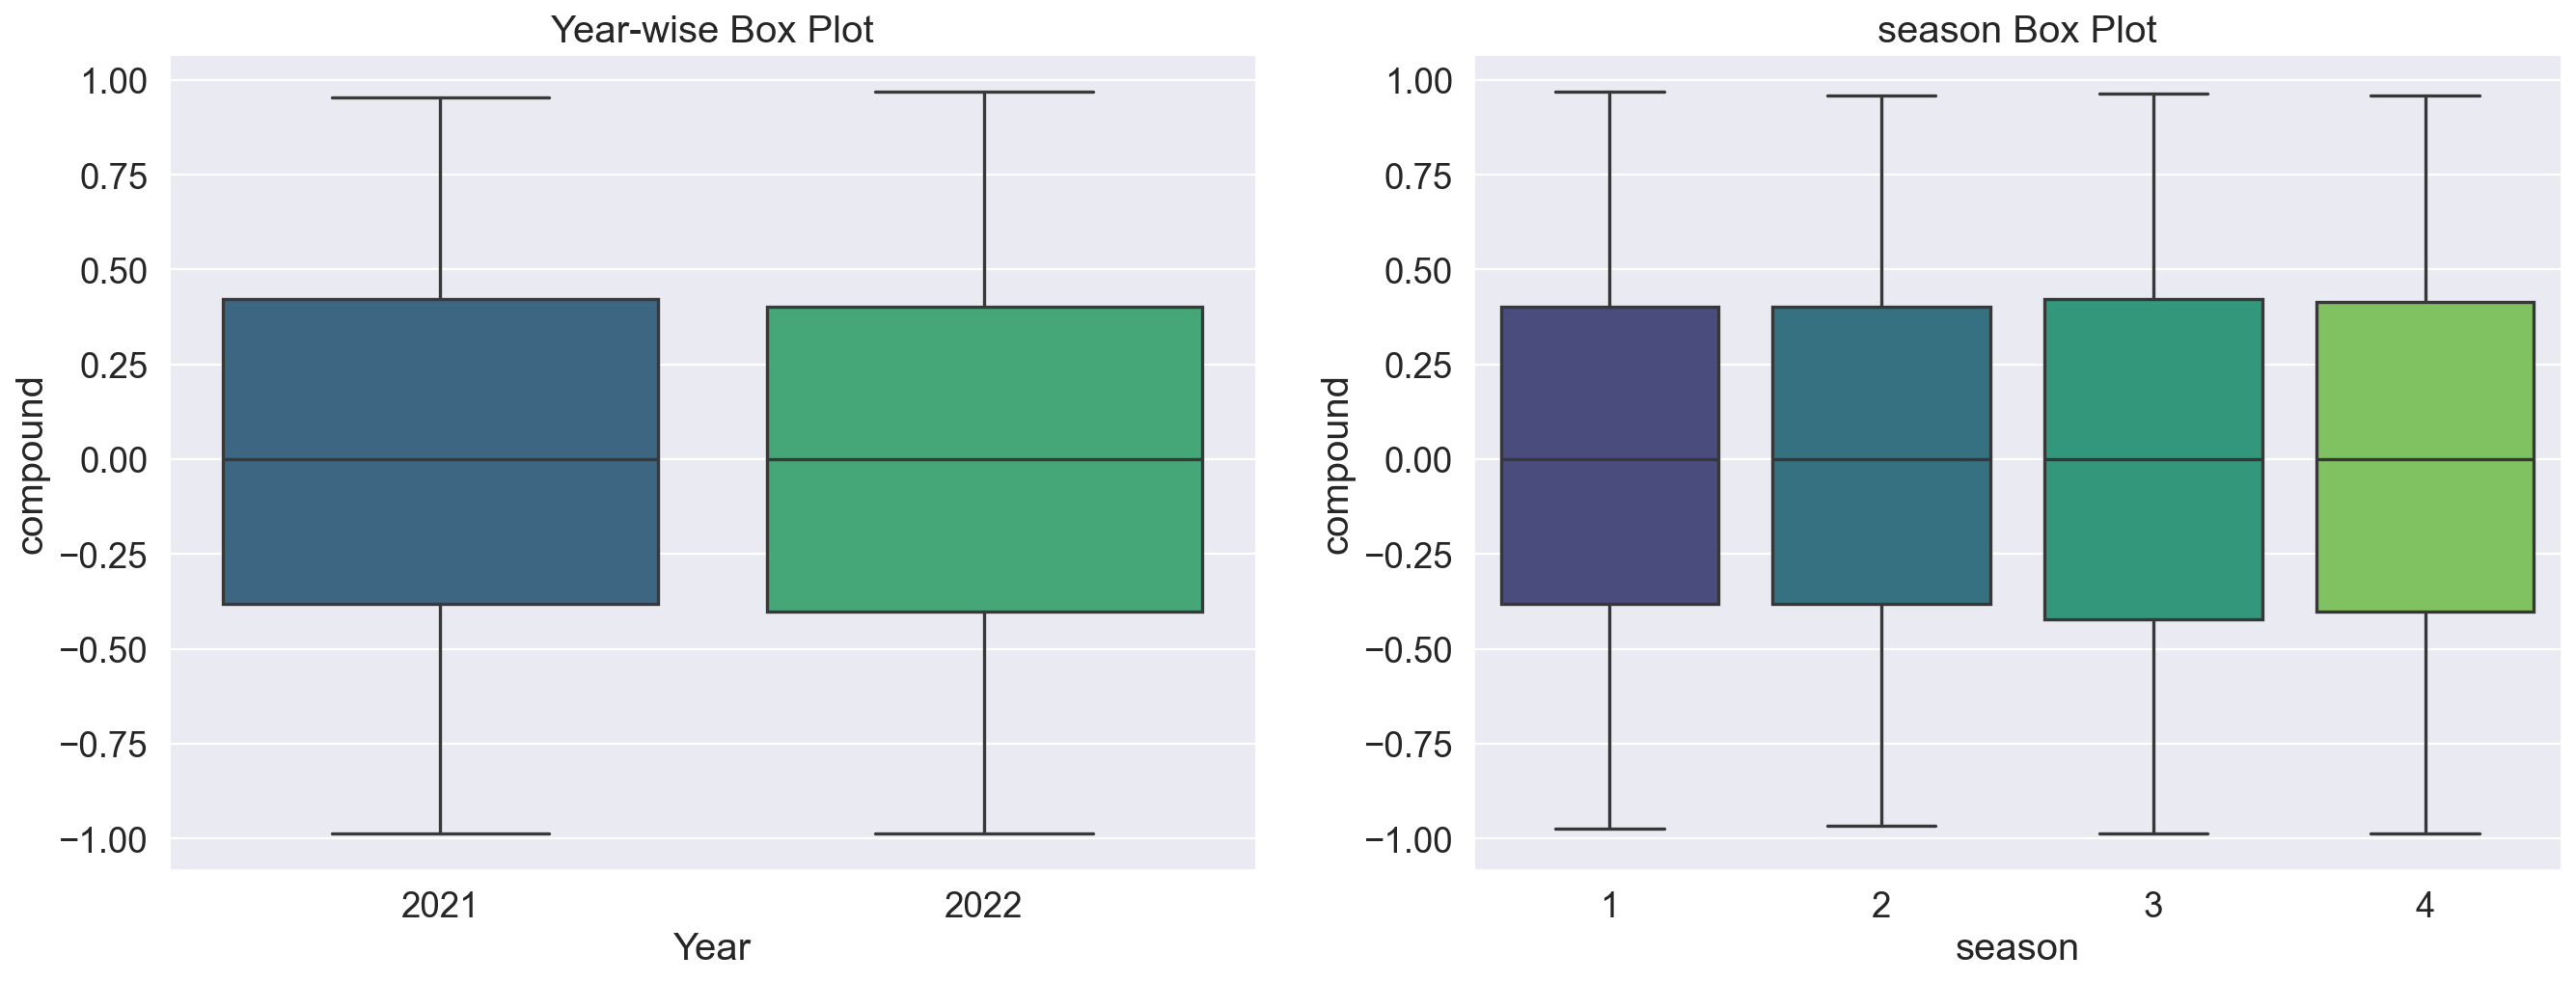

In [75]:
#call styles for plots
styles();
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='compound', data=df, ax=axes[0], palette='viridis')
sns.boxplot(x='season', y='compound', data=df, ax=axes[1] , palette='viridis')

# Set Title
axes[0].set_title('Year-wise Box Plot', fontsize=18); 
axes[1].set_title('season Box Plot', fontsize=18)


plt.show()

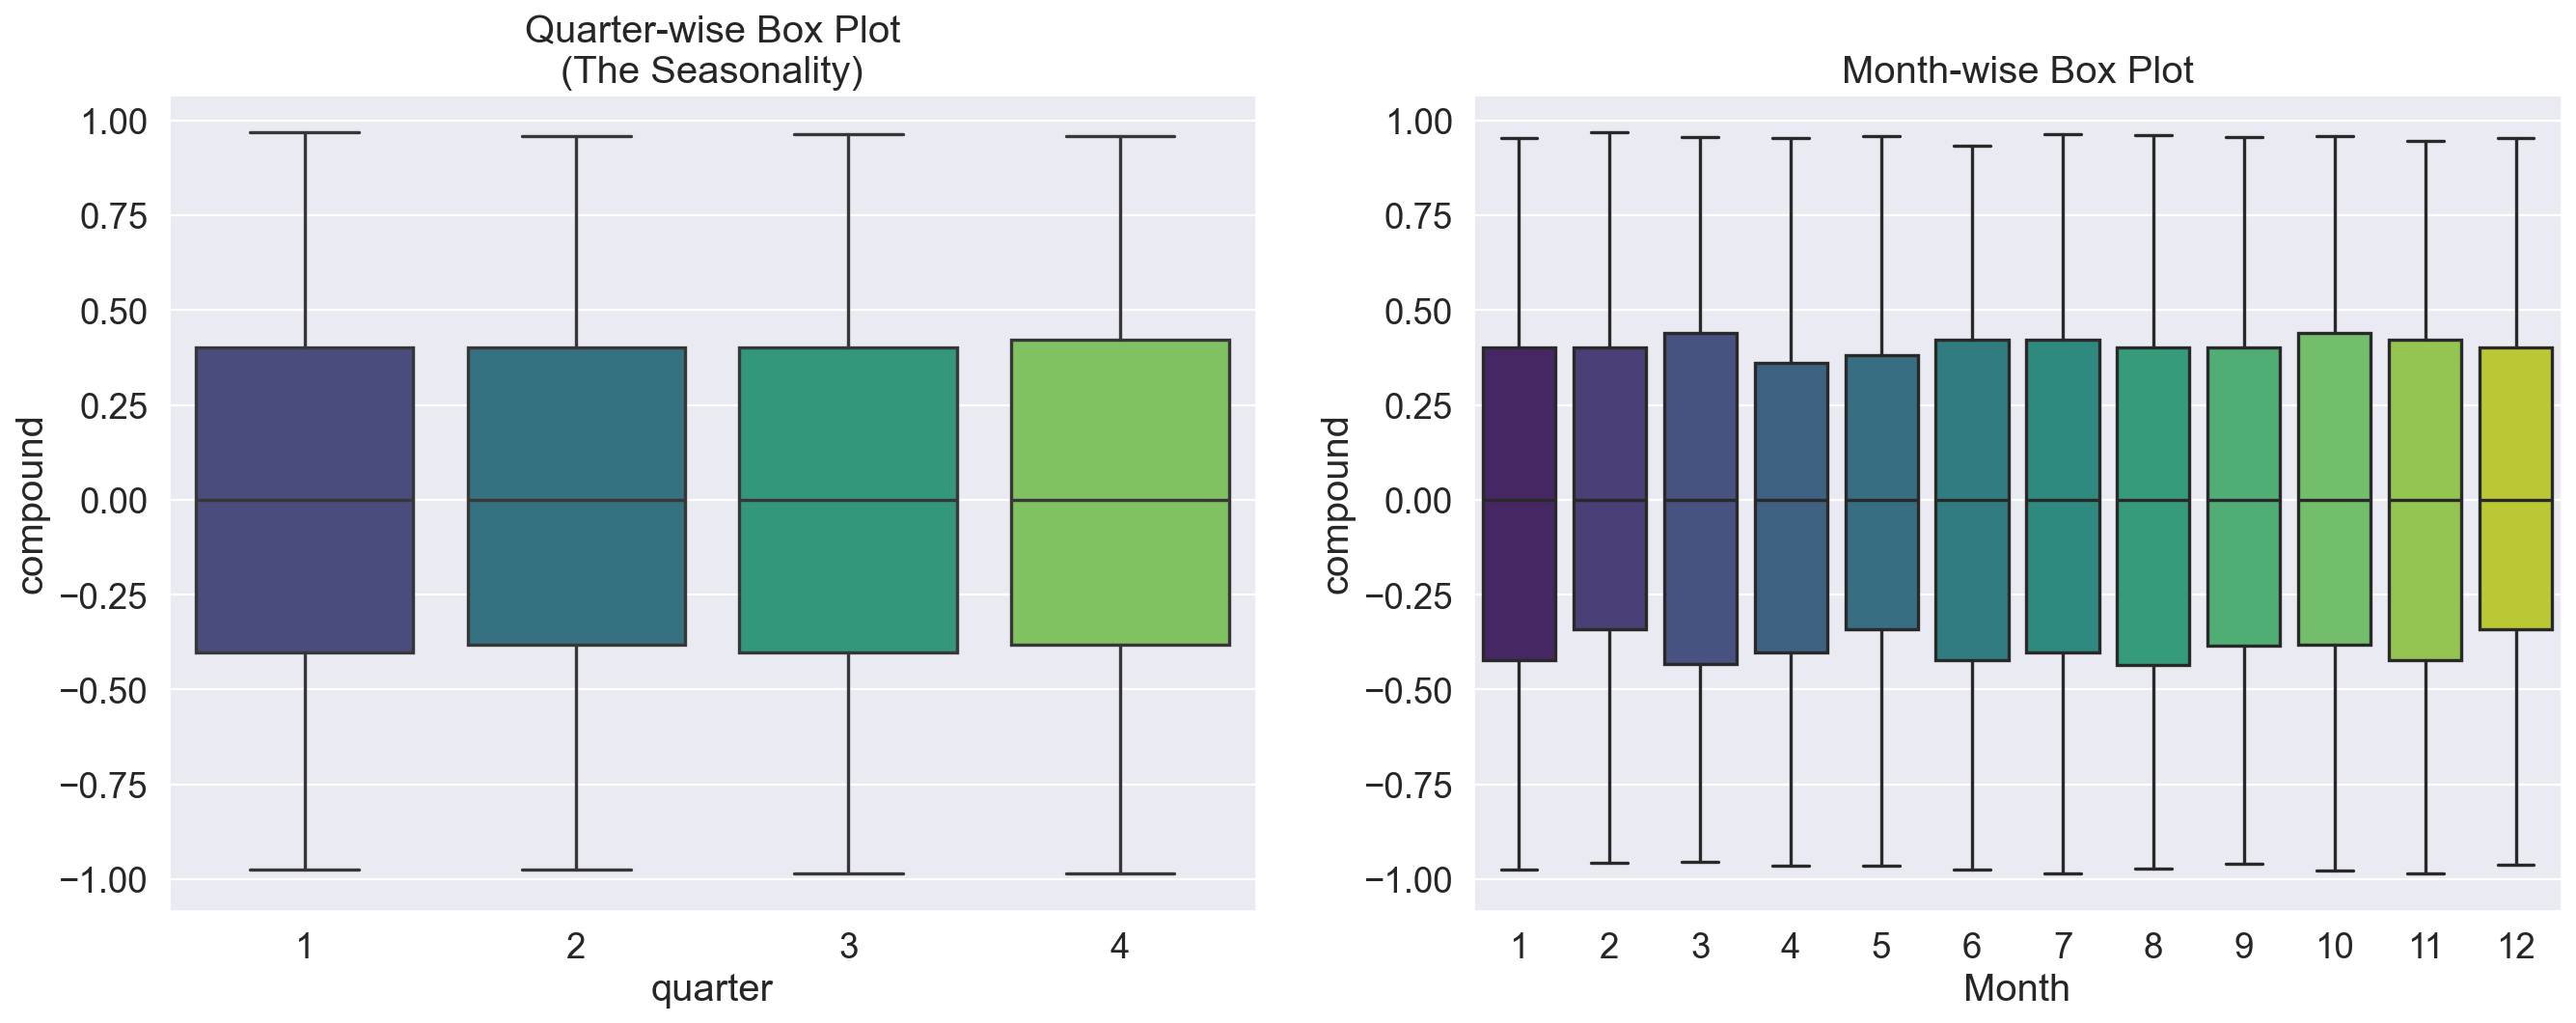

In [76]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)


sns.boxplot(x='quarter', y='compound', data=df, ax=axes[0] , palette='viridis')
sns.boxplot(x='Month', y='compound', data=df, ax=axes[1], palette='viridis');


# Set Title
axes[0].set_title('Quarter-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[1].set_title('Month-wise Box Plot', fontsize=18); 




plt.show();

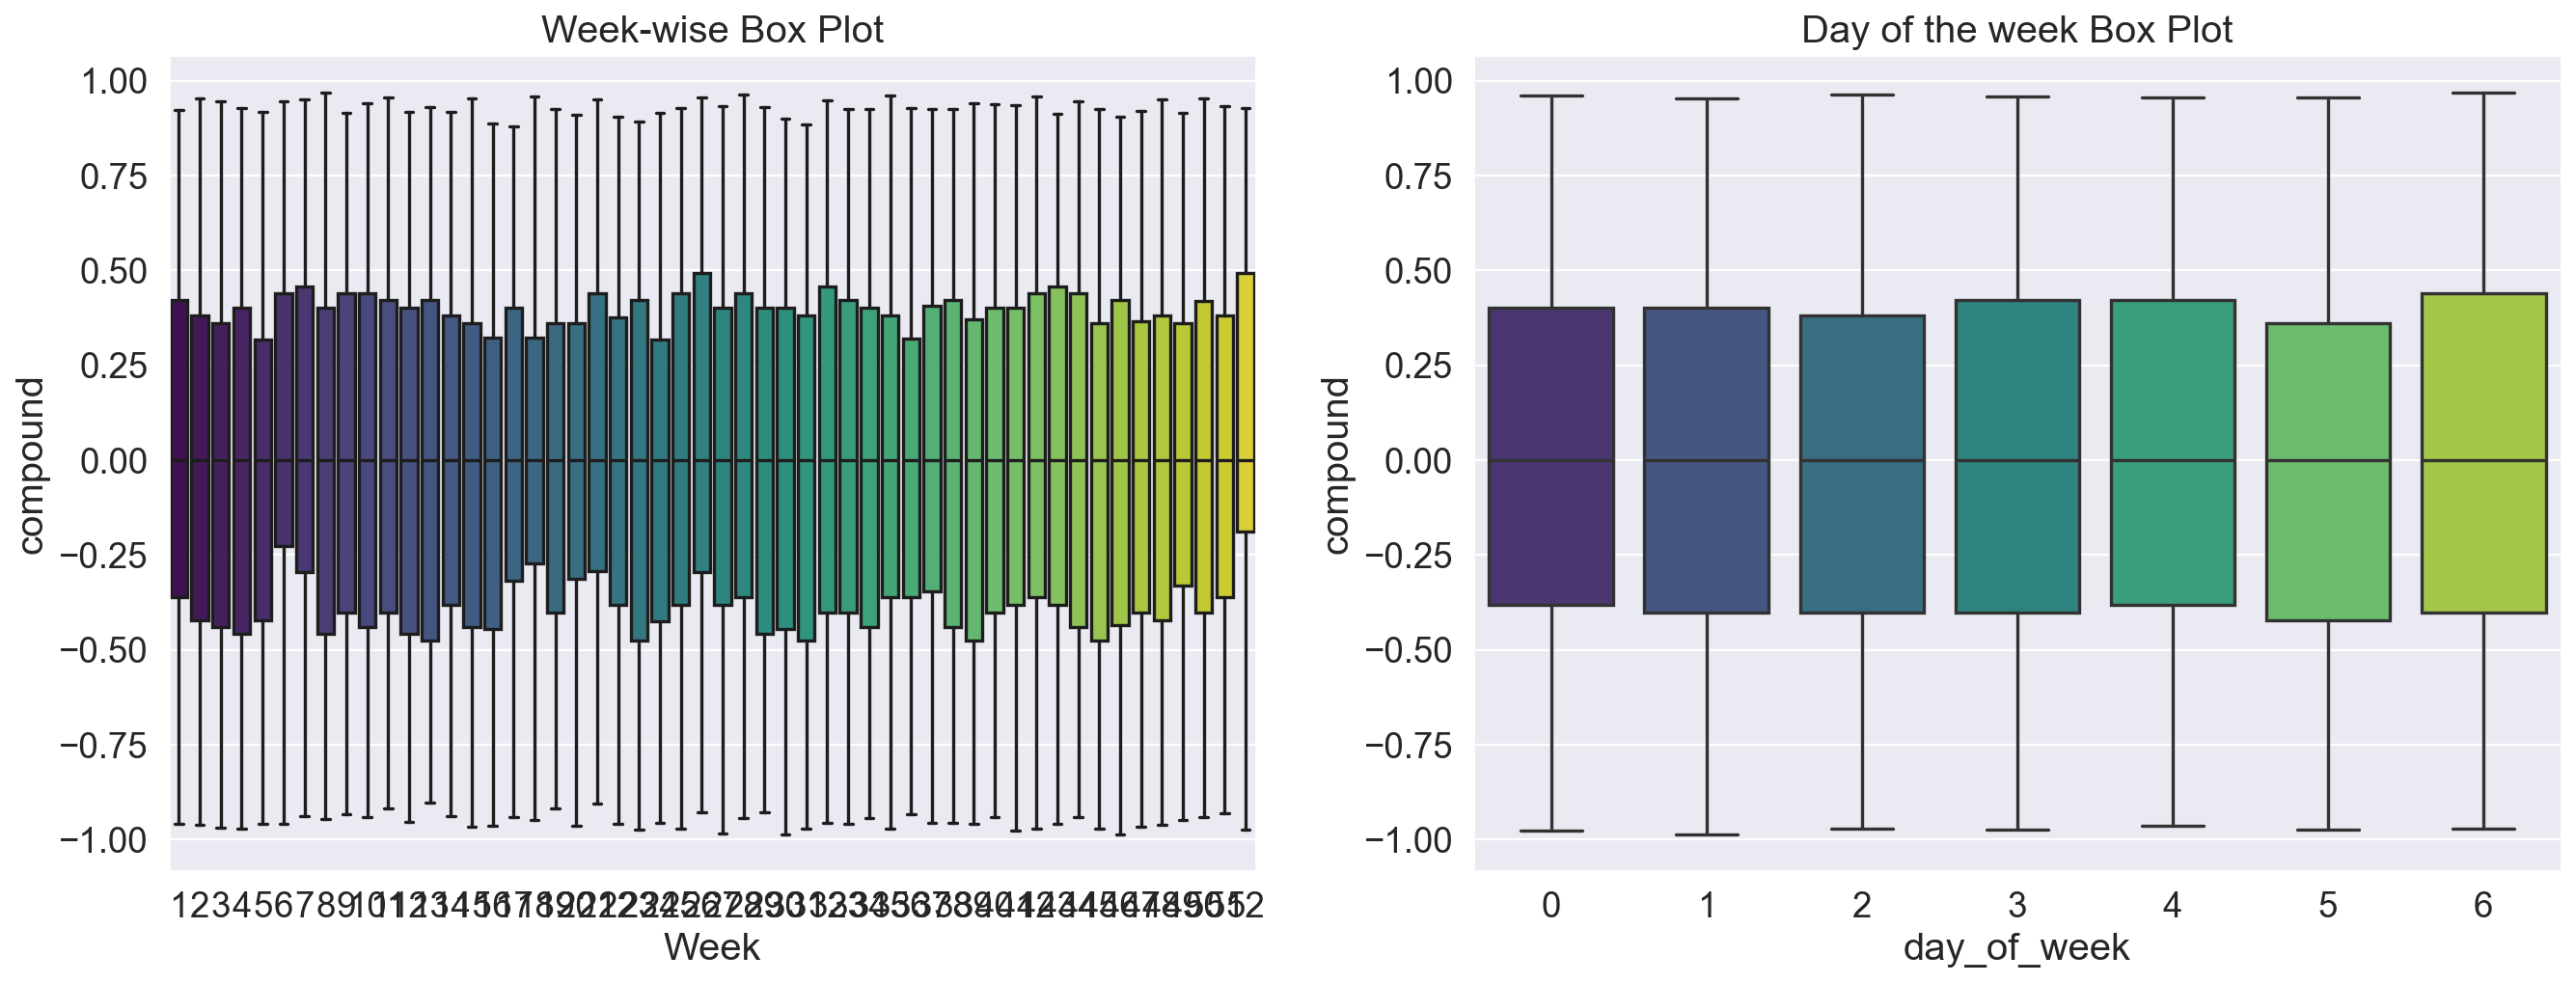

In [77]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)

sns.boxplot(x='Week', y='compound', data=df, ax=axes[0], palette='viridis');
sns.boxplot(x='day_of_week', y='compound', data=df, ax=axes[1], palette='viridis');

# Set Title
axes[0].set_title('Week-wise Box Plot', fontsize=18);
axes[1].set_title('Day of the week Box Plot', fontsize=18); 

plt.show();

## Boris

In [78]:
df_boris = df[df['tweet_clean'].str.contains("boris", case=False)]

In [79]:
df_boris.describe()

retweetCount   likeCount       Month         Year        Week  \
count    366.000000  366.000000  366.000000   366.000000  366.000000   
mean       1.300546    4.046448    6.128415  2021.775956   24.655738   
std        7.165928   21.501718    3.670305     0.417522   15.833606   
min        0.000000    0.000000    1.000000  2021.000000    1.000000   
25%        0.000000    0.000000    3.000000  2022.000000    9.000000   
50%        0.000000    0.000000    6.000000  2022.000000   24.000000   
75%        0.000000    1.000000    9.000000  2022.000000   38.750000   
max       85.000000  339.000000   12.000000  2022.000000   52.000000   

       day_of_year  day_of_week     quarter      season  word_count  \
count   366.000000   366.000000  366.000000  366.000000  366.000000   
mean    170.595628     2.775956    2.396175    2.281421   34.568306   
std     111.117513     1.995631    1.162843    1.115291   14.221515   
min       2.000000     0.000000    1.000000    1.000000    4.000000   
25%      63.250000     1.000000    1.000000    1.000000   23.000000   
50%     168.500000     3.000000    2.000000    2.000000   36.000000   
75%     263.500000     5.000000    3.000000    3.000000   45.000000   
max     364.000000     6.000000    4.000000    4.000000  105.000000   

       char_count   stopwords  hashtag_count    polarity  subjectivity  \
count  366.000000  366.000000     366.000000  366.000000    366.000000   
mean   232.535519   11.076503       3.114754    0.020882      0.365468   
std    102.357325    6.154597       3.801651    0.266128      0.290146   
min     48.000000    0.000000       0.000000   -1.000000      0.000000   
25%    161.750000    6.000000       0.000000   -0.050000      0.070833   
50%    249.000000   11.000000       2.000000    0.000000      0.384848   
75%    284.000000   16.000000       5.000000    0.158542      0.539167   
max    966.000000   26.000000      26.000000    1.000000      1.000000   

       Positive Sentiment  Neutral Sentiment  Negative Sentiment    compound  
count          366.000000         366.000000          366.000000  366.000000  
mean             0.127875           0.735433            0.136681   -0.007531  
std              0.118957           0.155676            0.140606    0.503085  
min              0.000001           0.233001            0.000001   -0.953099  
25%              0.000001           0.627251            0.000001   -0.440399  
50%              0.118001           0.741501            0.114501    0.000001  
75%              0.210501           0.826751            0.213751    0.401901  
max              0.615001           1.000001            0.767001    0.904201

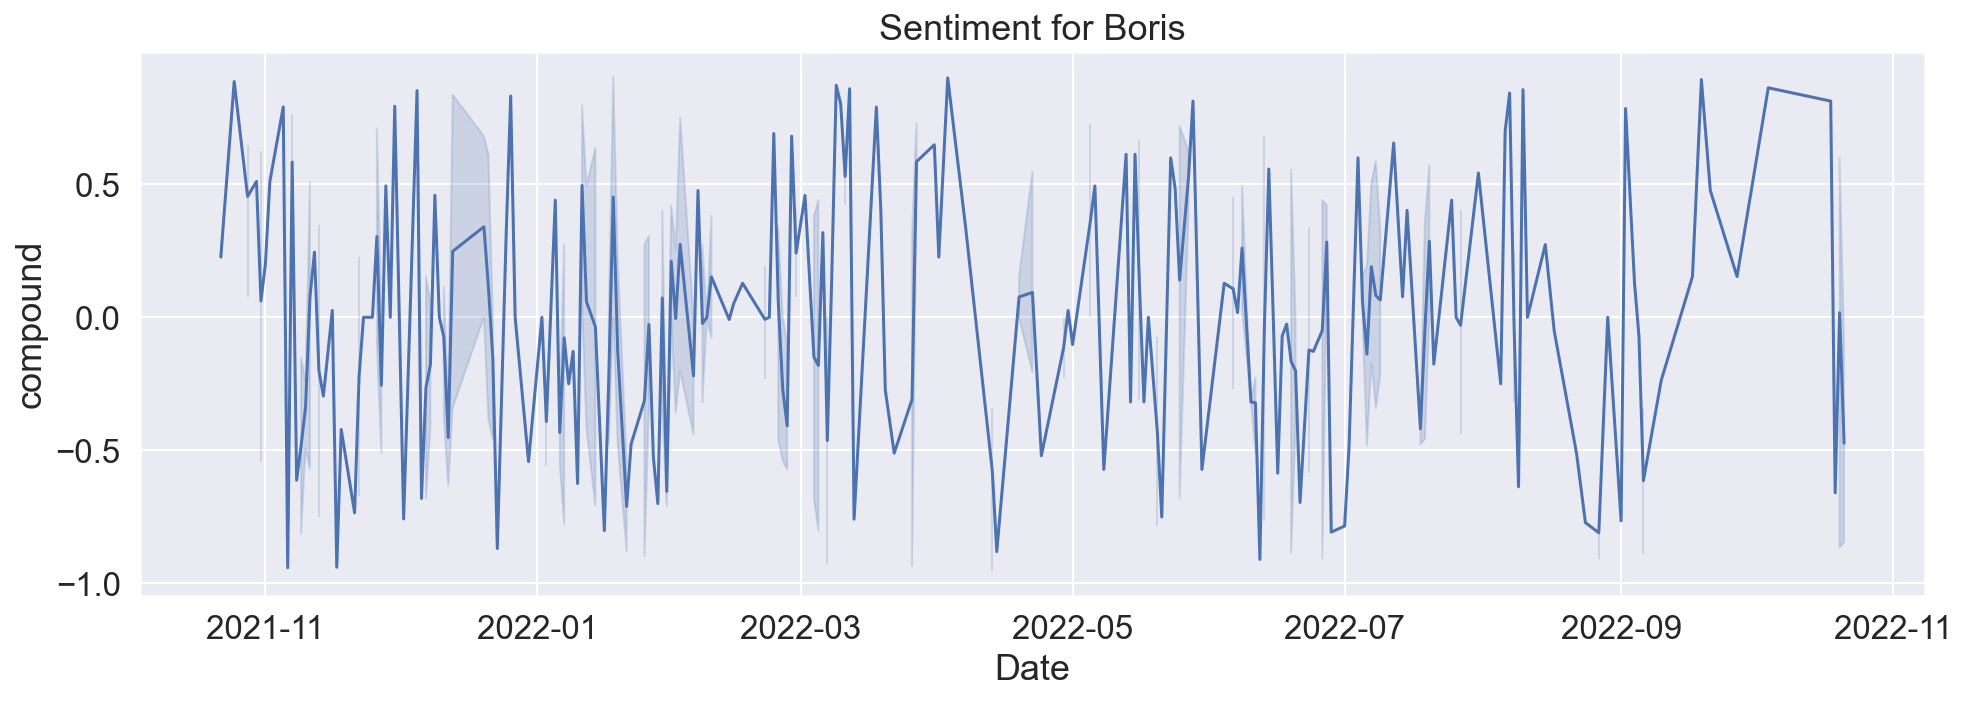

In [80]:
styles();

sns.lineplot(x=df_boris['Date'], y=df_boris['compound']);

plt.title("Sentiment for Boris");

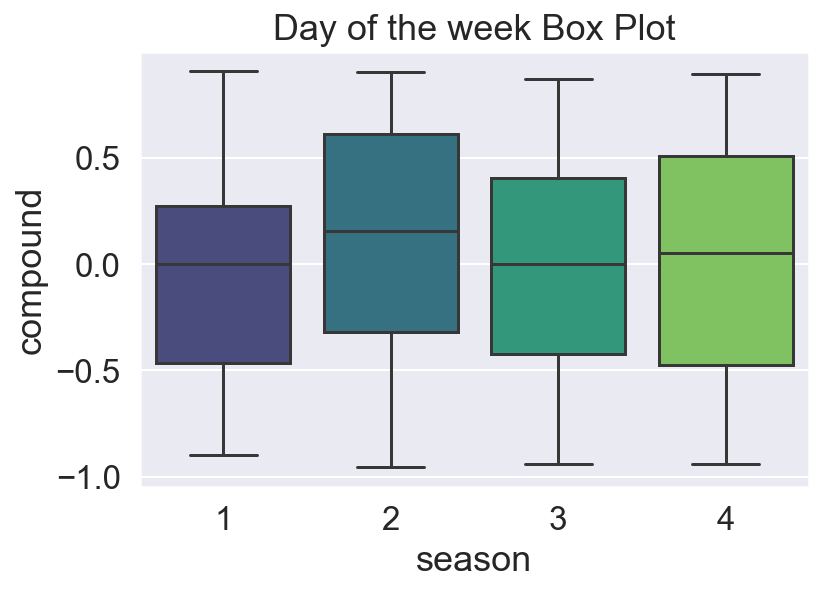

In [81]:
sns.boxplot(x='season', y='compound', data=df_boris, palette='viridis');

plt.title('Day of the week Box Plot', fontsize=18); 

plt.show();

In [ ]:
#pip install --upgrade scalecast

In [2]:
#pip install lightgbm

In [82]:
from scalecast.Forecaster import Forecaster

In [95]:
df_cmpd_avg.reset_index('Date', inplace=True)

KeyError: 'Requested level (Date) does not match index name (None)'

In [96]:
f = Forecaster(y=df_cmpd_avg['compound_daily'],
                   current_dates=df_cmpd_avg['Date'])

In [97]:
f

Forecaster(
    DateStartActuals=2021-10-22T00:00:00.000000000
    DateEndActuals=2022-10-22T00:00:00.000000000
    Freq=None
    N_actuals=18481
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [102]:
f.set_test_length(30)       # 1. 12 observations to test the results
f.generate_future_dates(30) # 2. 12 future points to forecast
f.set_estimator('lstm')     # 3. LSTM neural network

577/577 [==============================] - 1s 999us/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

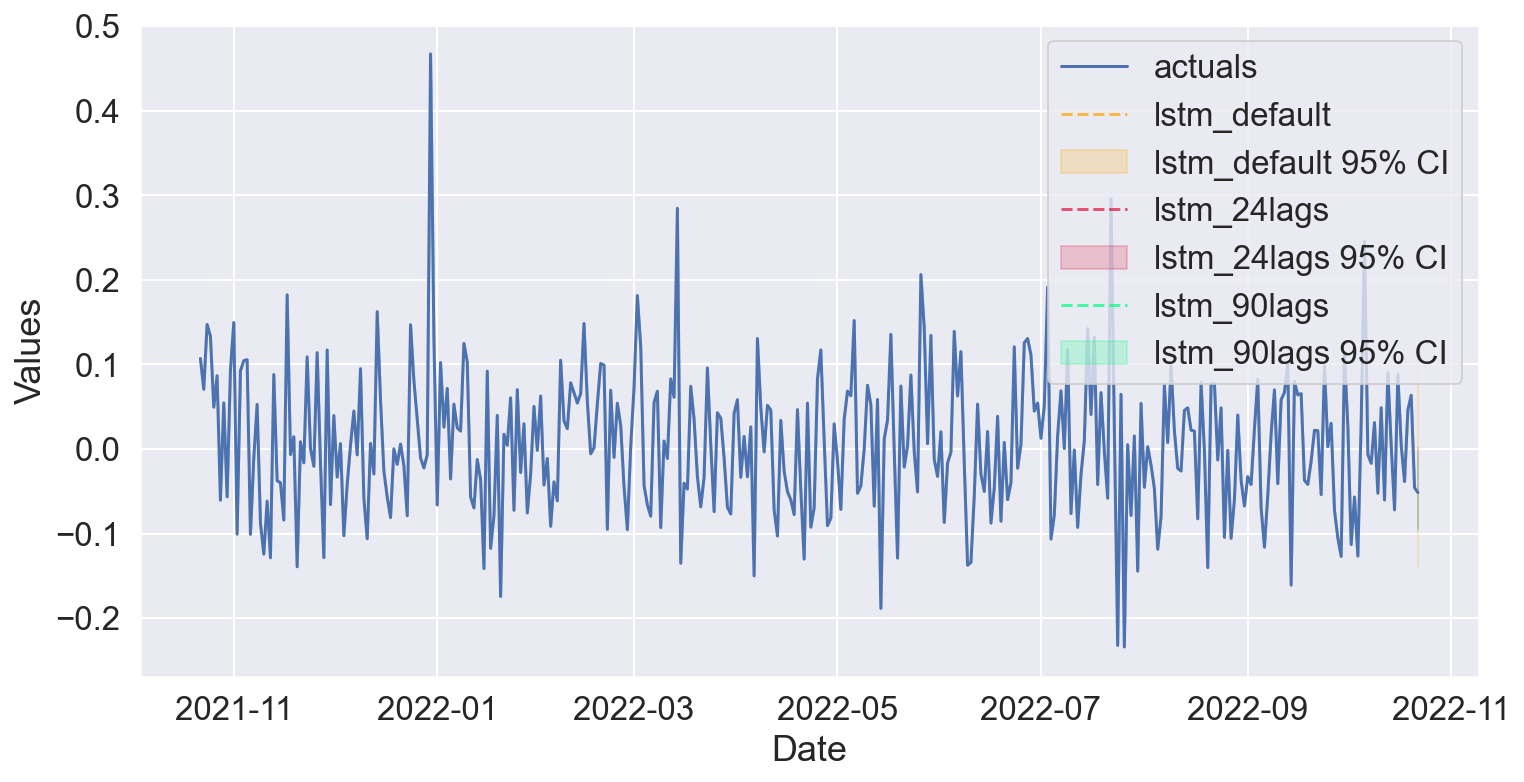

In [103]:
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

577/577 [==============================] - 1s 2ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

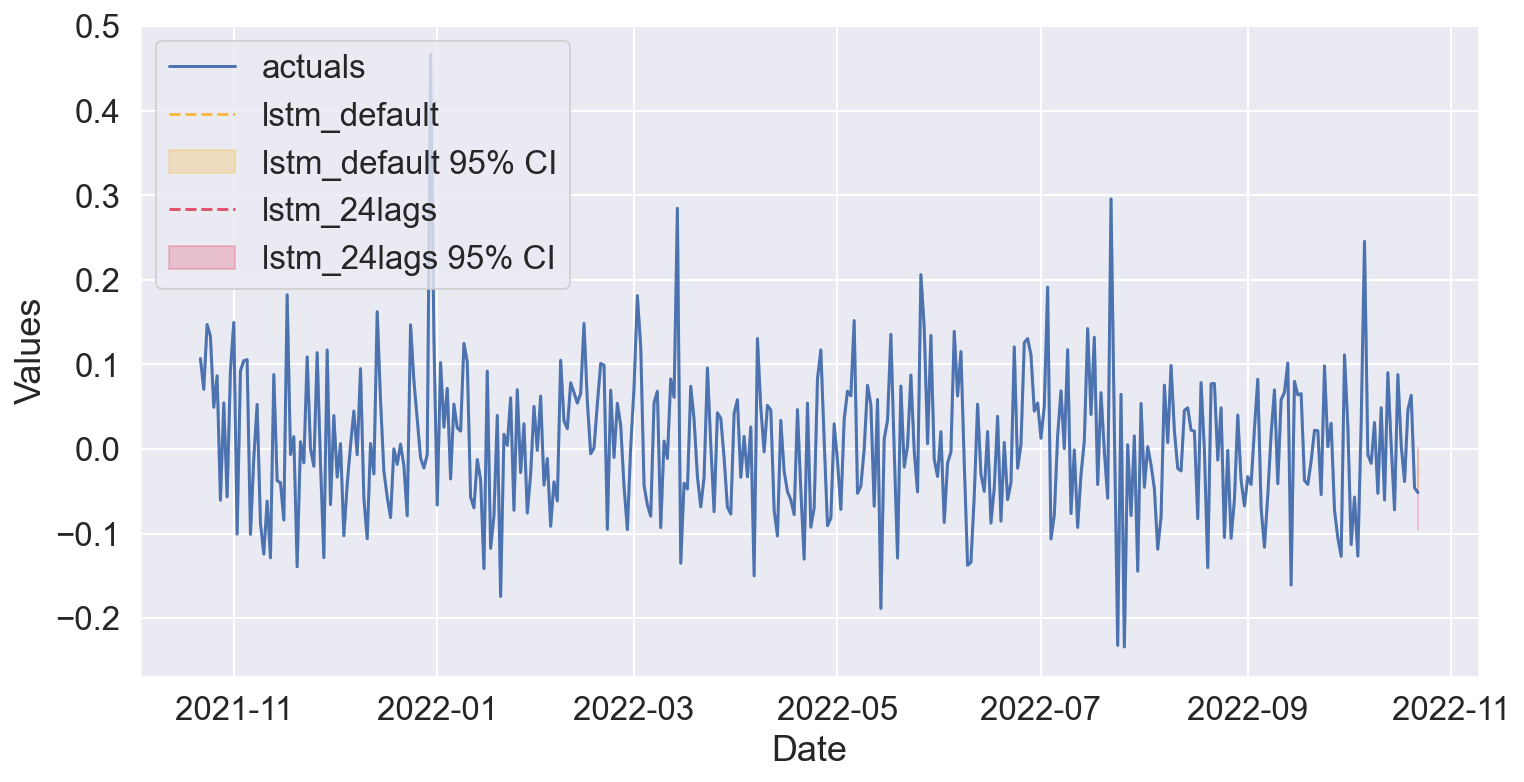

In [100]:
f.manual_forecast(call_me='lstm_24lags',lags=24)
f.plot_test_set(ci=True)

575/575 [==============================] - 4s 7ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

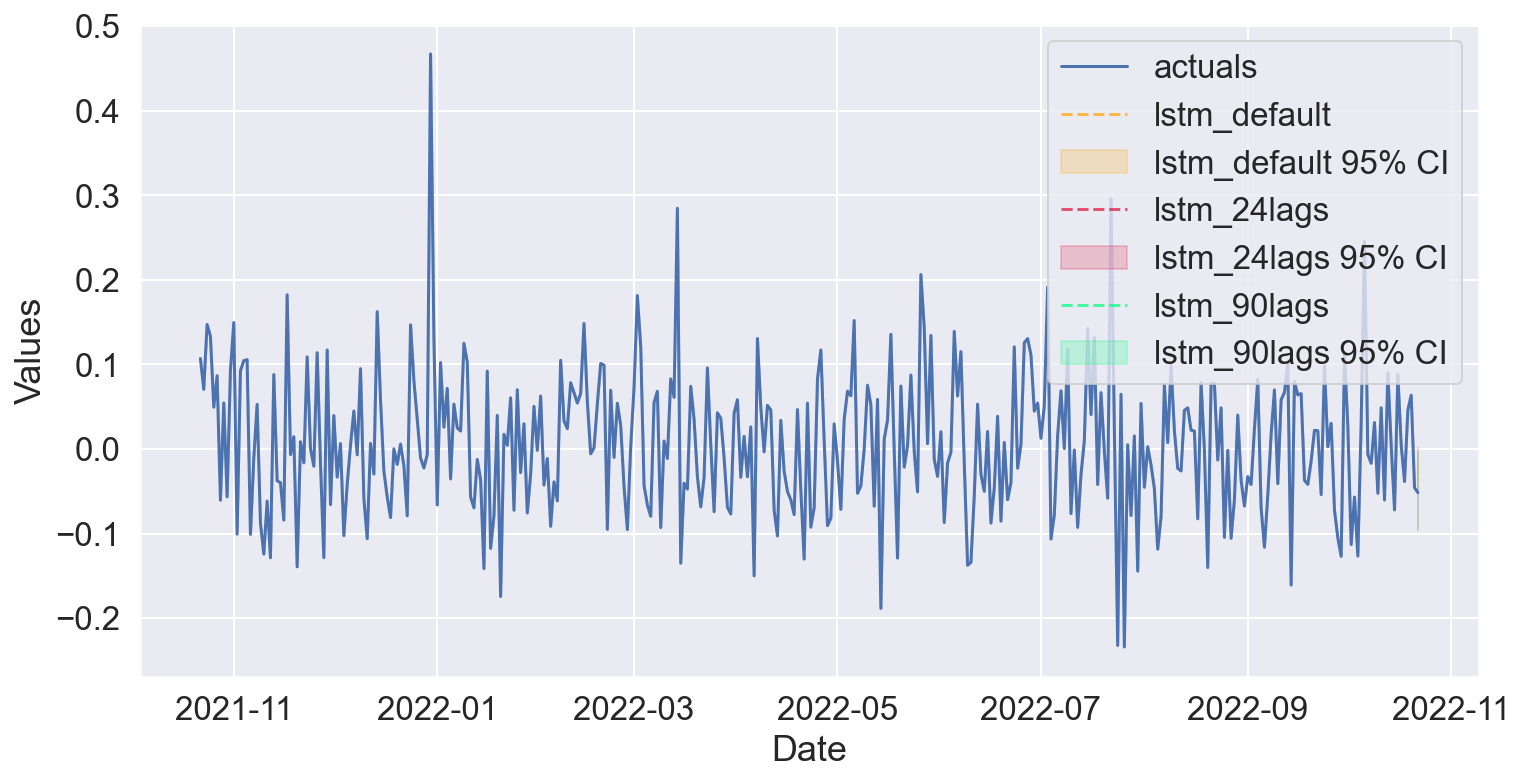

In [101]:
f.manual_forecast(call_me='lstm_90lags',lags=90)
f.plot_test_set(ci=True)

Epoch 1/25
460/460 [==============================] - 16s 25ms/step - loss: 0.0819 - val_loss: 0.0635
Epoch 2/25
460/460 [==============================] - 11s 24ms/step - loss: 0.0518 - val_loss: 0.0564
Epoch 3/25
460/460 [==============================] - 11s 23ms/step - loss: 0.0474 - val_loss: 0.0527
Epoch 4/25
460/460 [==============================] - 10s 23ms/step - loss: 0.0447 - val_loss: 0.0510
Epoch 5/25
460/460 [==============================] - 10s 23ms/step - loss: 0.0434 - val_loss: 0.0517
Epoch 6/25
460/460 [==============================] - 10s 22ms/step - loss: 0.0421 - val_loss: 0.0486
Epoch 7/25
460/460 [==============================] - 10s 22ms/step - loss: 0.0411 - val_loss: 0.0470
Epoch 8/25
460/460 [==============================] - 10s 22ms/step - loss: 0.0412 - val_loss: 0.0470
Epoch 9/25
460/460 [==============================] - 10s 22ms/step - loss: 0.0405 - val_loss: 0.0467
Epoch 10/25
460/460 [==============================] - 10s 22ms/step - loss: 0.040

<AxesSubplot:xlabel='Date', ylabel='Values'>

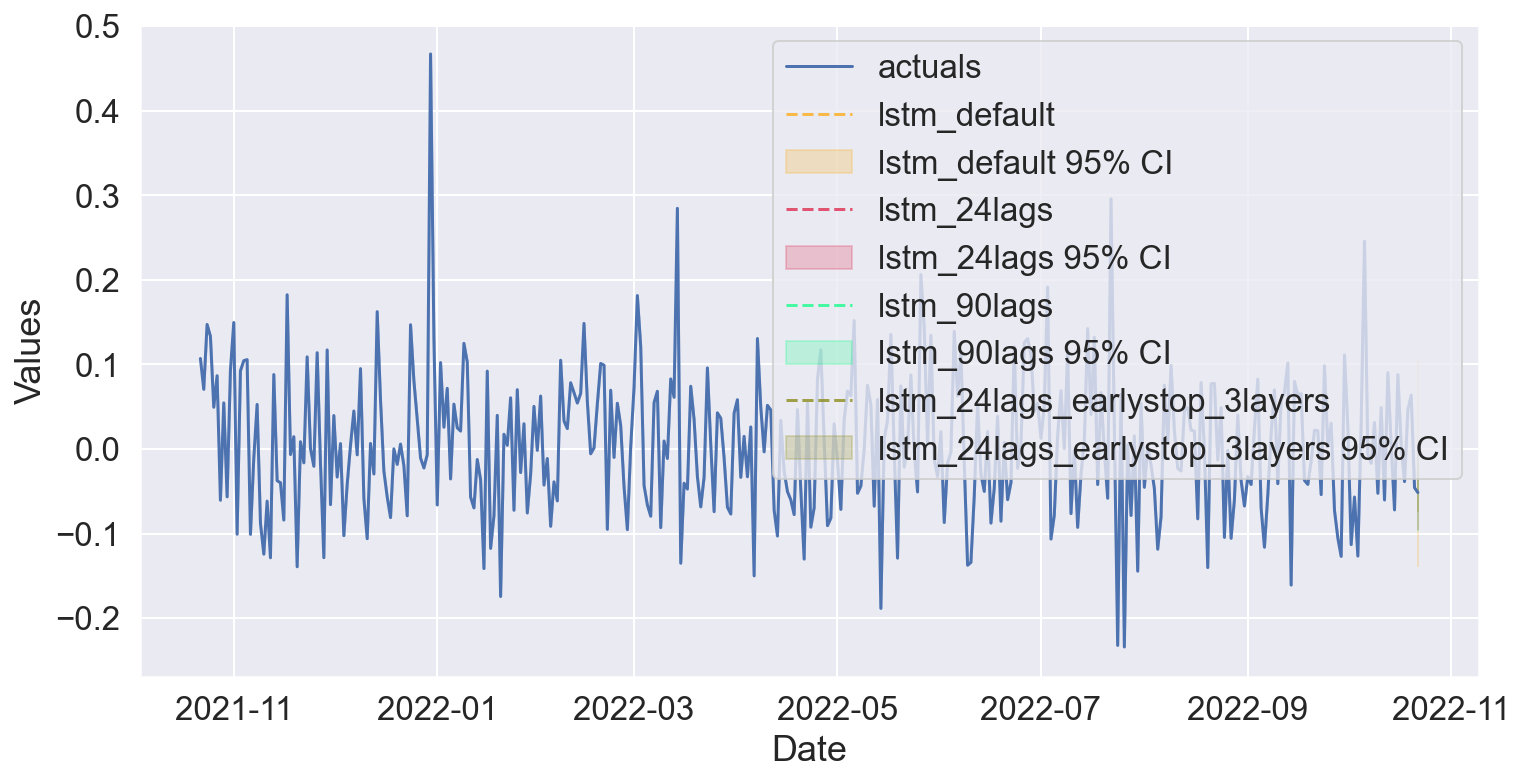

In [104]:
from tensorflow.keras.callbacks import EarlyStopping
f.manual_forecast(call_me='lstm_24lags_earlystop_3layers',
                  lags=24,
                  epochs=25,
                  validation_split=.2,
                  shuffle=True,
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=5),
                  lstm_layer_sizes=(16,16,16),
                  dropout=(0,0,0))
f.plot_test_set(ci=True)

<AxesSubplot:xlabel='Date', ylabel='Values'>

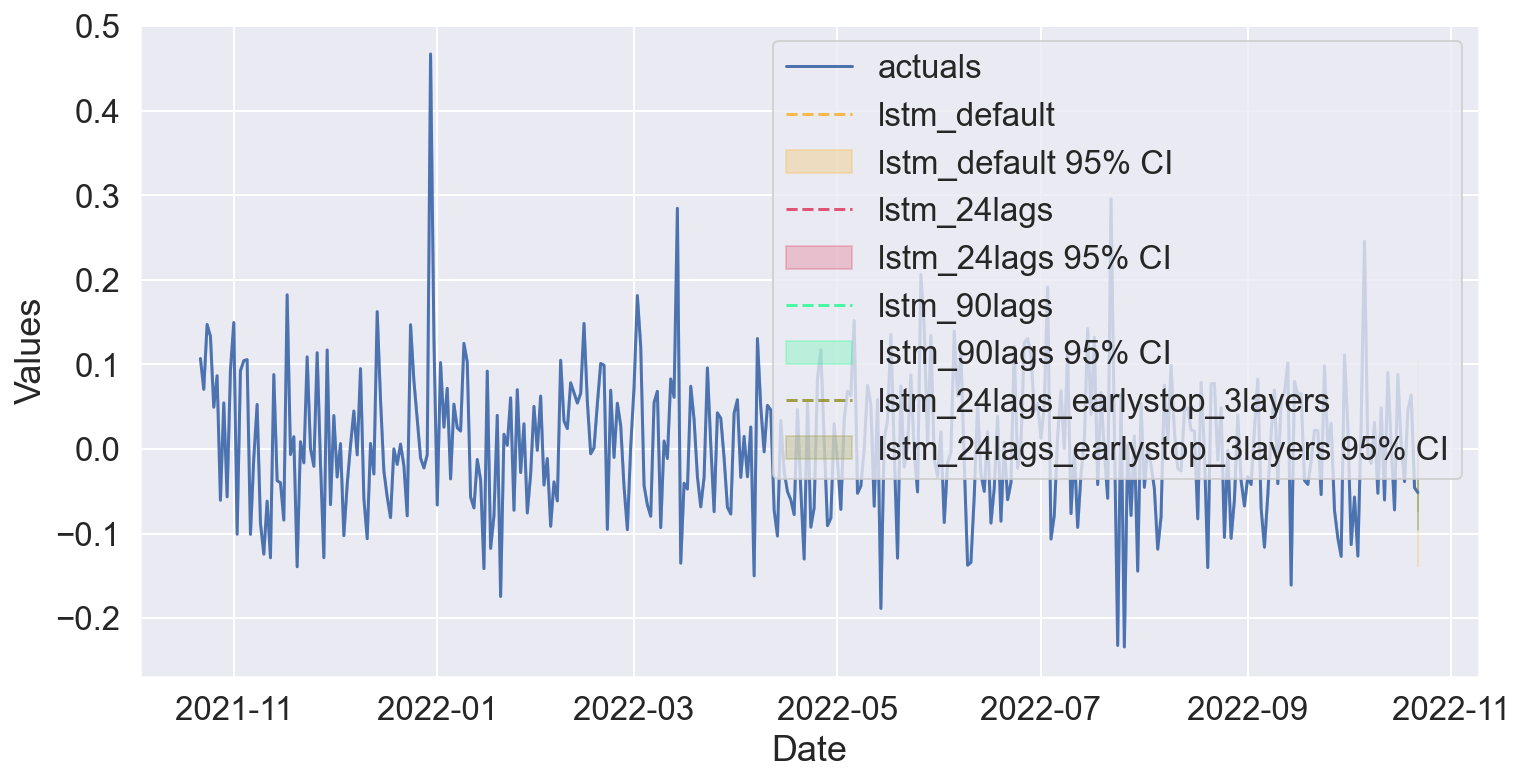

In [105]:
f.plot_test_set(ci=True)

In [106]:
f.set_test_length(90)       # 1. 12 observations to test the results
f.generate_future_dates(90) # 2. 12 future points to forecast
f.set_estimator('lstm')     # 3. LSTM neural network

575/575 [==============================] - 1s 1ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

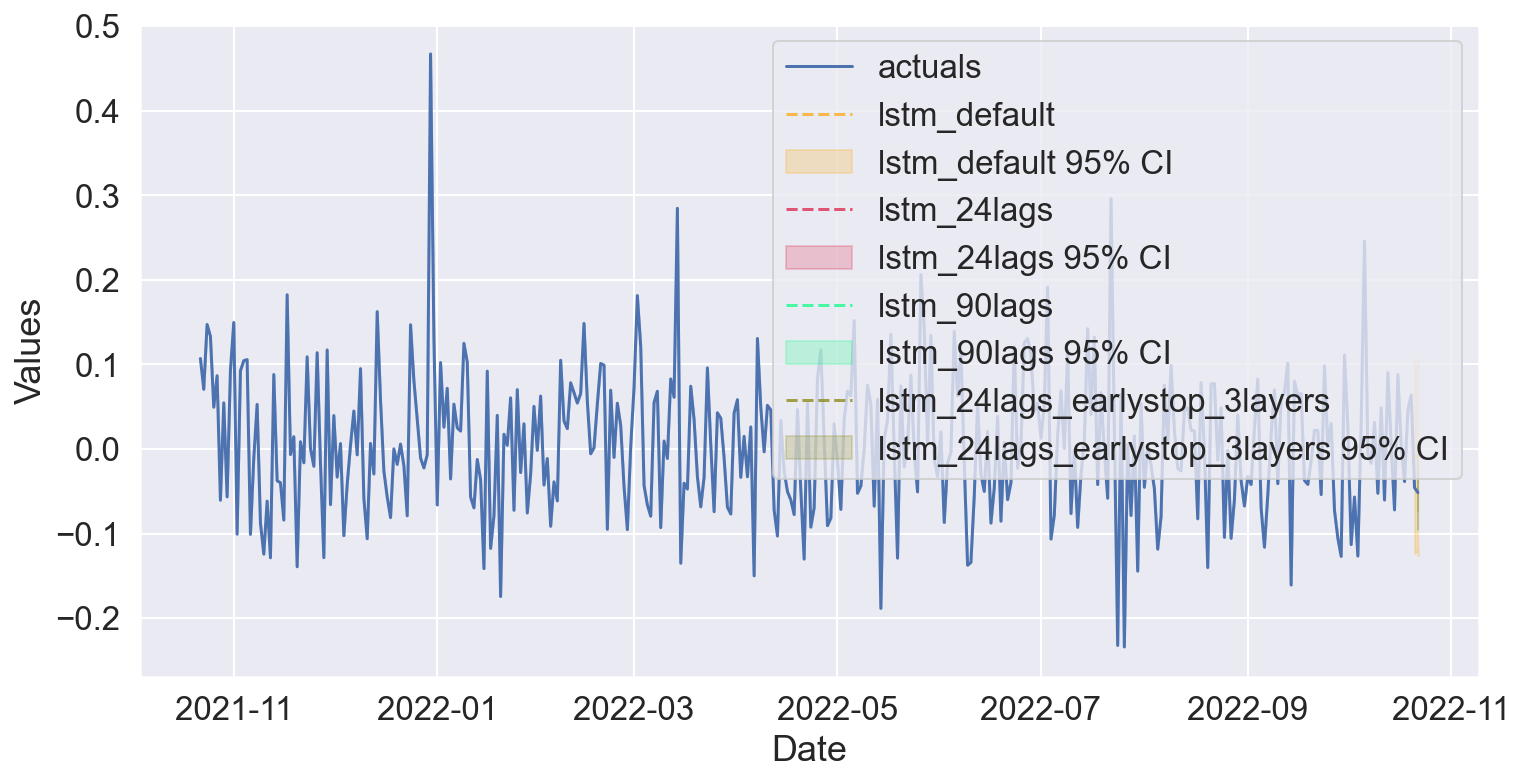

In [107]:
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

Epoch 1/15
458/458 [==============================] - 16s 20ms/step - loss: 0.0929 - val_loss: 0.0913
Epoch 2/15
458/458 [==============================] - 9s 19ms/step - loss: 0.0782 - val_loss: 0.0883
Epoch 3/15
458/458 [==============================] - 7s 15ms/step - loss: 0.0777 - val_loss: 0.0870
Epoch 4/15
458/458 [==============================] - 7s 15ms/step - loss: 0.0769 - val_loss: 0.0863
Epoch 5/15
458/458 [==============================] - 8s 18ms/step - loss: 0.0767 - val_loss: 0.0855
Epoch 6/15
458/458 [==============================] - 8s 18ms/step - loss: 0.0756 - val_loss: 0.0853
Epoch 7/15
458/458 [==============================] - 7s 15ms/step - loss: 0.0750 - val_loss: 0.0854
Epoch 8/15
458/458 [==============================] - 9s 19ms/step - loss: 0.0743 - val_loss: 0.0835
Epoch 9/15
458/458 [==============================] - 8s 17ms/step - loss: 0.0737 - val_loss: 0.0834
Epoch 10/15
458/458 [==============================] - 6s 14ms/step - loss: 0.0732 - val_l

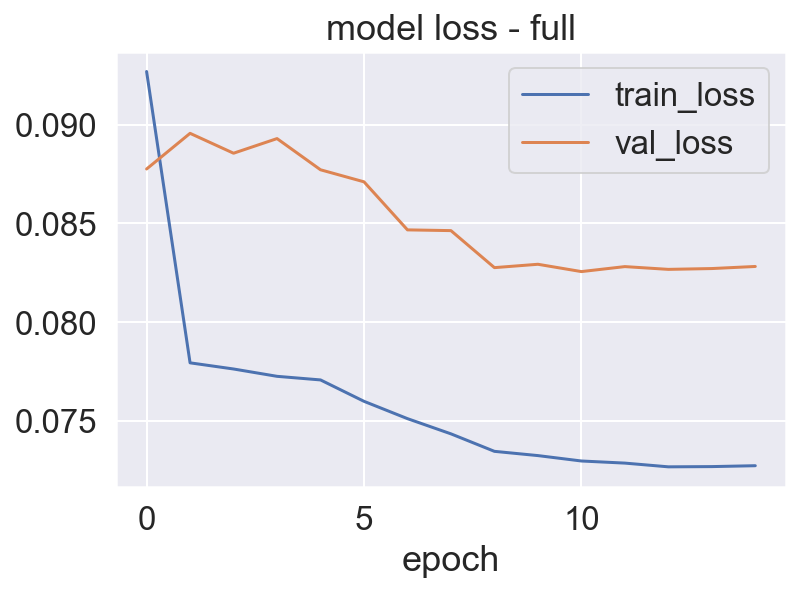

575/575 [==============================] - 3s 5ms/step


In [109]:
f.manual_forecast(call_me='lstm_best',
                  lags=6,
                  batch_size=32,
                  epochs=15,
                  validation_split=.2,
                  shuffle=True,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)

<AxesSubplot:xlabel='Date', ylabel='Values'>

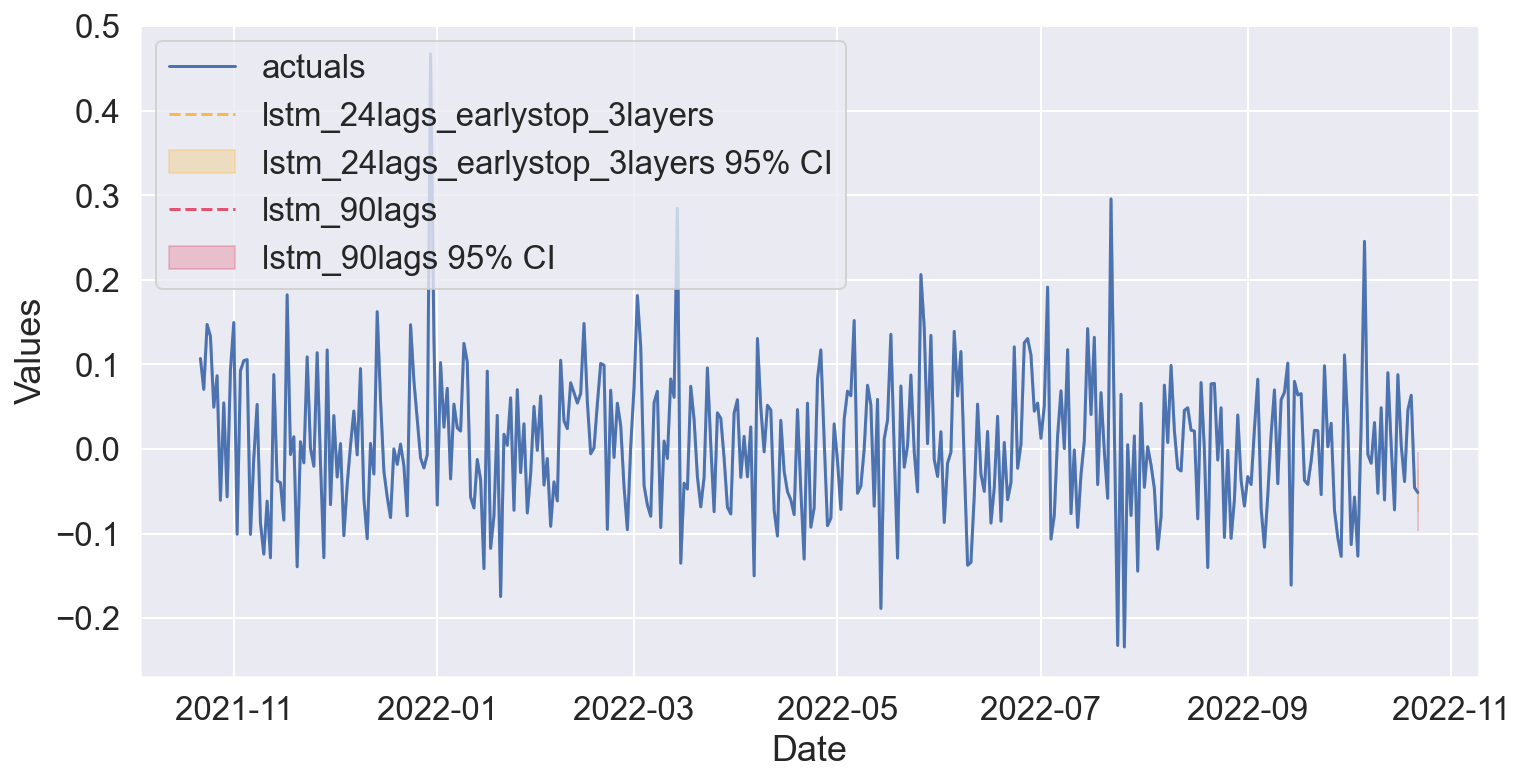

In [110]:
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2',ci=True)